# **Analisis de mercado inmobiliario de la región AMBA**

## Elementos del proyecto:


### 1. EDA
* Carga de librerías
* Carga de dataset e inspección
* Detección de valores faltantes
* Imputacion de valores faltantes
* Detección y eliminación de Outliers
* Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
* Preguntas sobre los datos estadísticos relevantes
* Encoding
* Generación de nuevas variables predictoras
* Transformación logarítmica
* Escalado de datos
* Clustering
* Reducción de dimensionalidad (PCA)

### 2. Modelos de aprendizaje
* Baseline: Arboles, KNN, Regresión lineal
* Modelos avanzados: XGBoost & Random Forest con RandomSearch CV
* Regresión Avanzada: Polynomial features, Ridge, Lasso y Elastic Net
* Comparativa de modelos
* Justificación de modelo elegido y comparación con tp1

## **1. EDA**
### **Carga de librerias**

In [1]:
%%capture
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2.5})

### **Carga de dataset e inspección**

In [2]:
prop = pd.read_csv('DS_Proyecto_02_Datos_Properati.csv')

In [3]:
prop.head(2)

start_date    end_date  created_on        lat        lon         l1  \
0  2019-10-17  2019-12-23  2019-10-17 -34.605880 -58.384949  Argentina   
1  2019-10-17  2019-11-21  2019-10-17 -34.624056 -58.412110  Argentina   

                l2             l3  rooms  bedrooms  bathrooms  surface_total  \
0  Capital Federal  San Cristobal    7.0       7.0        2.0          140.0   
1  Capital Federal          Boedo    2.0       1.0        2.0           70.0   

   surface_covered     price currency  \
0            140.0  153000.0      USD   
1             58.0  159000.0      USD   

                                              title  \
0       ***Venta semipiso centro, ideal hostel*****   
1  Espectacular PH reciclado en Boedo sin expensas.   

                                         description property_type  \
0  DESCRIPCION DE LA PROPIEDAD: Departamento de 1...  Departamento   
1   PH reciclado en Boedo a una cuadra de la plaz...            PH   

  operation_type  
0          Venta  
1          Venta

Verifico el tamaño del dataset

In [4]:
prop.shape

(146660, 19)

In [5]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

Verifico los nombres de las columnas

In [6]:
prop.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

Podemos notar algunos outliers que estan sesgando muchisimo las distribuciones de las variables. Superficie total, superficie cubierta y precio tienen una desviación estandar muy fuera de lo común y muy por arriba de los 3 sigmas.

In [7]:
prop.describe()

lat            lon          rooms       bedrooms  \
count  136735.000000  136701.000000  146660.000000  146660.000000   
mean      -34.604896     -58.465304       3.079817       1.983240   
std         0.468428       0.486190       1.416352       1.151304   
min       -35.318457    -180.000000       1.000000       0.000000   
25%       -34.627667     -58.504012       2.000000       1.000000   
50%       -34.600943     -58.443262       3.000000       2.000000   
75%       -34.574600     -58.407586       4.000000       3.000000   
max        85.051129     -57.805832      35.000000      15.000000   

           bathrooms  surface_total  surface_covered         price  
count  140703.000000  126133.000000    125046.000000  1.466600e+05  
mean        1.599994     216.872888       112.818011  2.412211e+05  
std         0.889324    2037.606649       916.857584  3.185195e+05  
min         1.000000      10.000000         1.000000  5.500000e+03  
25%         1.000000      52.000000        47.000000  1.110000e+05  
50%         1.000000      78.000000        68.000000  1.660000e+05  
75%         2.000000     140.000000       108.000000  2.650000e+05  
max        14.000000  193549.000000    126062.000000  3.243423e+07

### **Detección de valores faltantes**

In [8]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns



In [9]:
missing= missing_values_table(prop)
missing

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values
surface_covered           21614               14.7
surface_total             20527               14.0
lon                        9959                6.8
lat                        9925                6.8
bathrooms                  5957                4.1

Vemos que coinciden muchos valores faltantes de surface_total con surface_covered, cuyos valores son importantes para el modelo. Lo mismo pasa en todos los casos de la latitud y longitud.

### Coincidencias en los valores faltantes

<AxesSubplot:>

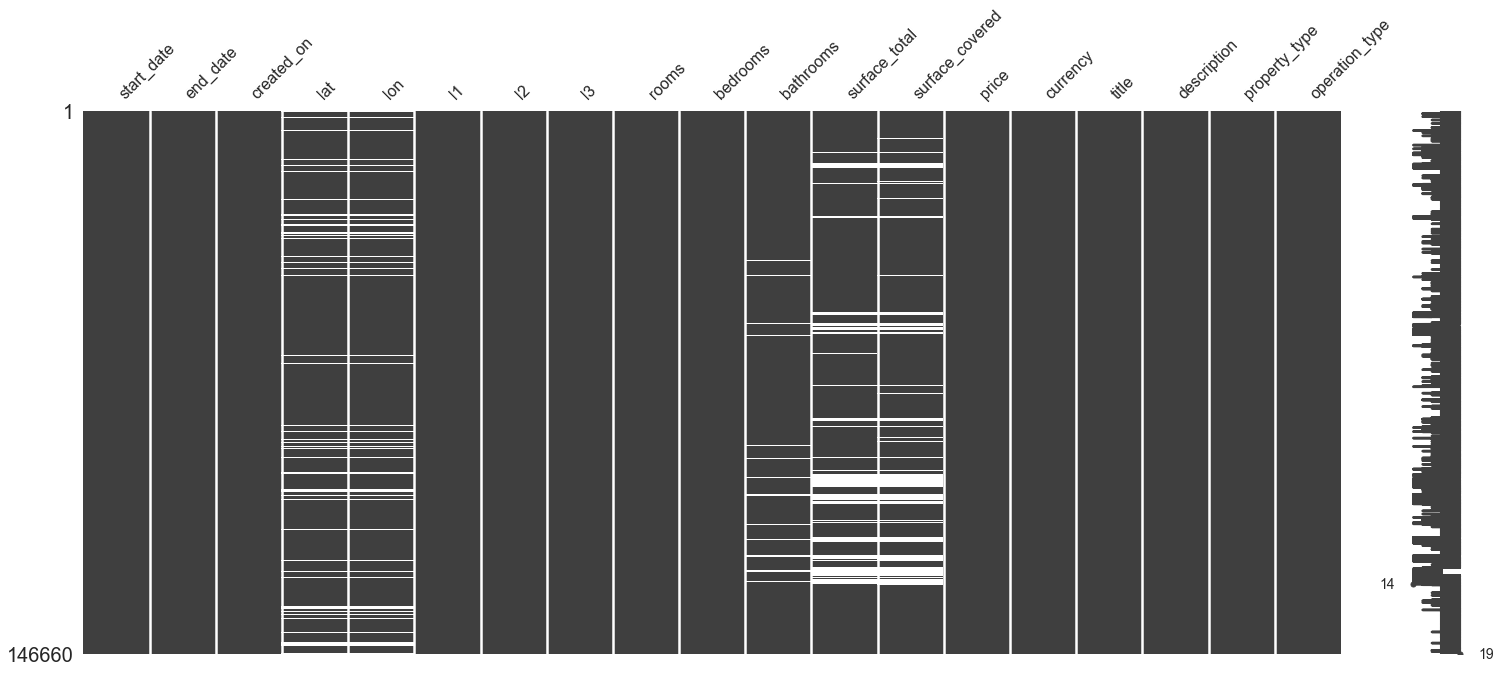

In [10]:
msno.matrix(prop)
#otra forma con HEATMAP
#sns.heatmap(prop.isnull(), yticklabels= False, cbar= False, cmap= 'viridis')

### Correlaciones entre valores faltantes

Notamos que todos los valores faltantes de latitud y longitud se corresponden uno a otro, y casi en igual medida para la superficie total y superficie cubierta.

<AxesSubplot:>

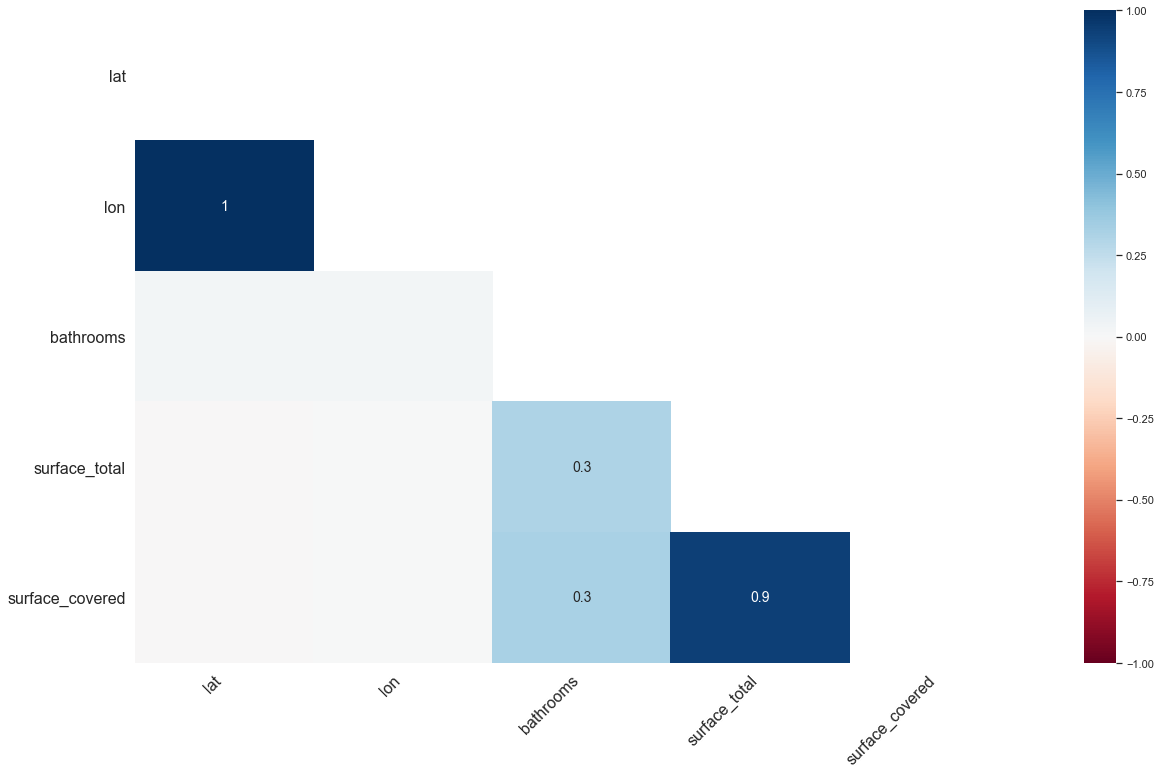

In [11]:
msno.heatmap(prop)

### **Imputación de valores faltantes**

Vemos que en algunos casos faltan valores de superficie descubierta y no de superficie total, por lo que imputaremos esos valores con los que sí tenemos. Primero imputamos los valores faltantes de superficie total con sus respectivos valores en superficie cubierta.

In [12]:
prop.surface_total = prop.surface_total.fillna(prop.surface_covered)
missing = missing_values_table(prop)
missing

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values
surface_covered           21614               14.7
surface_total             20012               13.6
lon                        9959                6.8
lat                        9925                6.8
bathrooms                  5957                4.1

Luego imputamos los valores faltantes de superficie cubierta por sus respectivos valores de superficie total.

In [13]:
prop.surface_covered = prop.surface_covered.fillna(prop.surface_total)
missing = missing_values_table(prop)
missing

Your selected dataframe has 19 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values
surface_total             20012               13.6
surface_covered           20012               13.6
lon                        9959                6.8
lat                        9925                6.8
bathrooms                  5957                4.1

### Correlaciones con otras variables

Ahora comprobamos si existe alguna correlación para los valores faltantes que quedaron. Probamos con varios gráficos y notamos que para los casos con gran cantidad de cuartos faltan sus valores de superficie, y bastantes de los baños también.

<AxesSubplot:>

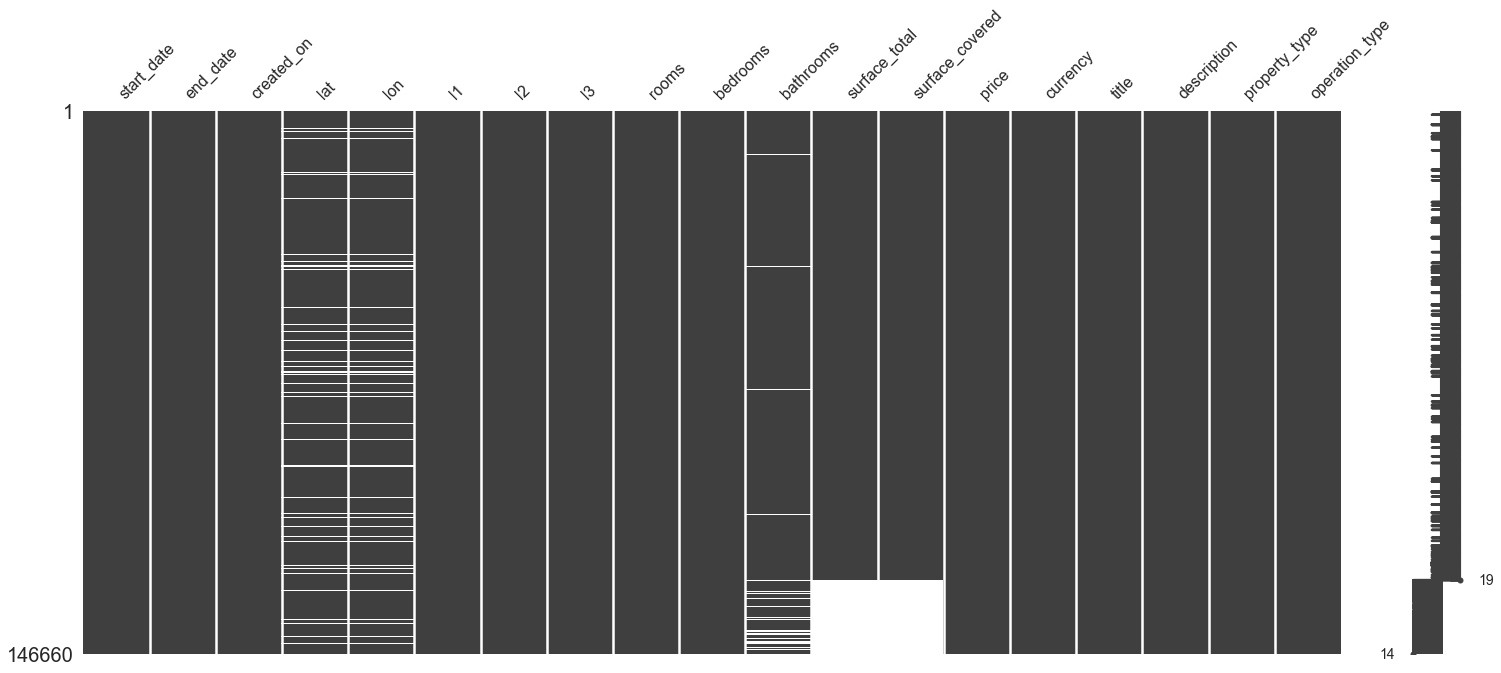

In [14]:
sorted = prop.sort_values('surface_total', ascending=True)
msno.matrix(sorted)

Como vemos a continuación, no parece haber alguna correlación de valores faltantes en baños con alguna otra variable, apenas el 30% con las superficies, pero es posible que su valor sea cero, ya que en algunos ejemplos vemos que tienen 1 cuarto, 1 dormitorio y valor nulo para el baño. También puede ser que se deduzca de los otros valores de cuartos y dormitorios. Analizando los títulos y descripciones no pude encontrar la información faltante.

In [15]:
prop.loc[prop['bathrooms'].isnull(),'value_is_NaN'] = 'Yes'
prop.loc[prop['bathrooms'].notnull(), 'value_is_NaN'] = 'No'
prop[prop['value_is_NaN'] == 'Yes']

start_date    end_date  created_on        lat        lon         l1  \
351     2019-03-04  2019-07-29  2019-03-04 -34.613973 -58.391633  Argentina   
360     2019-03-04  2019-03-12  2019-03-04 -34.619823 -58.437283  Argentina   
438     2019-03-04  2019-07-29  2019-03-04 -34.578135 -58.461733  Argentina   
473     2019-03-04  2019-07-15  2019-03-04 -34.683016 -58.354596  Argentina   
573     2019-07-09  2019-07-10  2019-07-09 -34.621374 -58.442597  Argentina   
...            ...         ...         ...        ...        ...        ...   
143631  2019-07-31  2020-01-17  2019-07-31        NaN        NaN  Argentina   
145136  2020-01-15  2020-01-20  2020-01-15 -34.365170 -58.763554  Argentina   
145346  2020-01-15  9999-12-31  2020-01-15 -34.638059 -58.584599  Argentina   
145950  2019-07-31  2019-08-13  2019-07-31        NaN        NaN  Argentina   
146459  2019-07-31  2019-10-13  2019-07-31 -34.586038 -58.438572  Argentina   

                              l2             l3  rooms  bedrooms  bathrooms  \
351              Capital Federal       Congreso    1.0       1.0        NaN   
360              Capital Federal      Caballito    1.0       1.0        NaN   
438              Capital Federal  Villa Ortuzar    4.0       3.0        NaN   
473       Bs.As. G.B.A. Zona Sur     Avellaneda    3.0       2.0        NaN   
573              Capital Federal      Caballito    2.0       1.0        NaN   
...                          ...            ...    ...       ...        ...   
143631  Bs.As. G.B.A. Zona Norte          Tigre    2.0       1.0        NaN   
145136  Bs.As. G.B.A. Zona Norte        Escobar    1.0       1.0        NaN   
145346  Bs.As. G.B.A. Zona Oeste          Morón    5.0       4.0        NaN   
145950  Bs.As. G.B.A. Zona Norte   San Fernando    2.0       1.0        NaN   
146459           Capital Federal        Palermo    2.0       1.0        NaN   

        surface_total  surface_covered     price currency  \
351              23.0             23.0   72000.0      USD   
360              14.0             14.0   27000.0      USD   
438              88.0             88.0  192000.0      USD   
473             370.0            370.0  149000.0      USD   
573              25.0             23.0   70000.0      USD   
...               ...              ...       ...      ...   
143631           65.0             53.0  222060.0      USD   
145136          888.0            888.0   39000.0      USD   
145346          302.0            302.0  209900.0      USD   
145950           59.0             51.0  189000.0      USD   
146459           45.0             45.0  170000.0      USD   

                                                    title  \
351          VENTA MONOAMBIENTE CONGRESO EXCELENTE ESTADO   
360              EXCELENTE COCHERA, EXCELENTE INVERSION !   
438     DEPTO.3 AMB Y DEP - AV. A. THOMAS  1395-V.ORTUZAR   
473          Casa de 3 amb Sarandi Lote de 42 x 8,66 mtrs   
573                                 DEPARTAMENTO EN VENTA   
...                                                   ...   
143631  LANZAMIENTO !!! Departamento 2 ambientes en ve...   
145136                               LOTE FINCAS DEL LAGO   
145346  Casa en 2 plantas a Reparar/Reciclar Barrio Gu...   
145950  Venta - Ruta Panamericana Ramal Pilar - Km 22 ...   
146459  PALERMO HOLLYWOOD, FITZ ROY,  AMBIENTES TODO L...   

                                              description property_type  \
351     Corredor Responsable: Damian Perrone - CUCICBA...  Departamento   
360     Corredor Responsable: Uno Bienes Raices SRL - ...  Departamento   
438     Corredor Responsable: Ariel Champanier - C.U.C...  Departamento   
473     Corredor Responsable: FRANCISCO D'ATRI - CPMCA...          Casa   
573     Xintel (MSD-MSD-50) <p>Departamento 2 AMBIENTE...  Departamento   
...                                                   ...           ...   
143631  Excelente Departamento 2 Ambientes  en venta d...  Departamento   
145136  Corredor Responsable: MAURO MARVISI 

### Eliminación de redundancias e inconsistencias

Notamos que hay que eliminar los casos donde el valor de la superficie cubierta supere al de la superficie total.

In [16]:
prop.shape

(146660, 20)

In [17]:
prop = prop[prop.surface_total >= prop.surface_covered]
prop[prop.surface_total < prop.surface_covered]

Empty DataFrame
Columns: [start_date, end_date, created_on, lat, lon, l1, l2, l3, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, title, description, property_type, operation_type, value_is_NaN]
Index: []

In [18]:
prop.shape

(125216, 20)

Eliminamos aquellas columnas que sean redundantes o no nos vayan a servir.

In [19]:
prop = prop.drop(['start_date','end_date','created_on','l1',
                  'currency','operation_type','value_is_NaN'], axis = 1)

### **Detección y eliminación de outliers**

Eliminamos los outliers de todas las variables numéricas para proseguir con la imputación de valores faltantes, ya que vamos a utilizar MICE. Agrupamos las variables en cualitativas y cuantitativas para facilitar el código.

In [20]:
quantitative = [f for f in prop.columns if prop.dtypes[f] != 'object']
qualitative = [f for f in prop.columns if prop.dtypes[f] == 'object']

Analizamos la distribución de cada variable para elegir la mejor manera de eliminar outliers. Notamos como antes que superficie total, superficie cubierta y precio presentan gran cantidad de outliers.

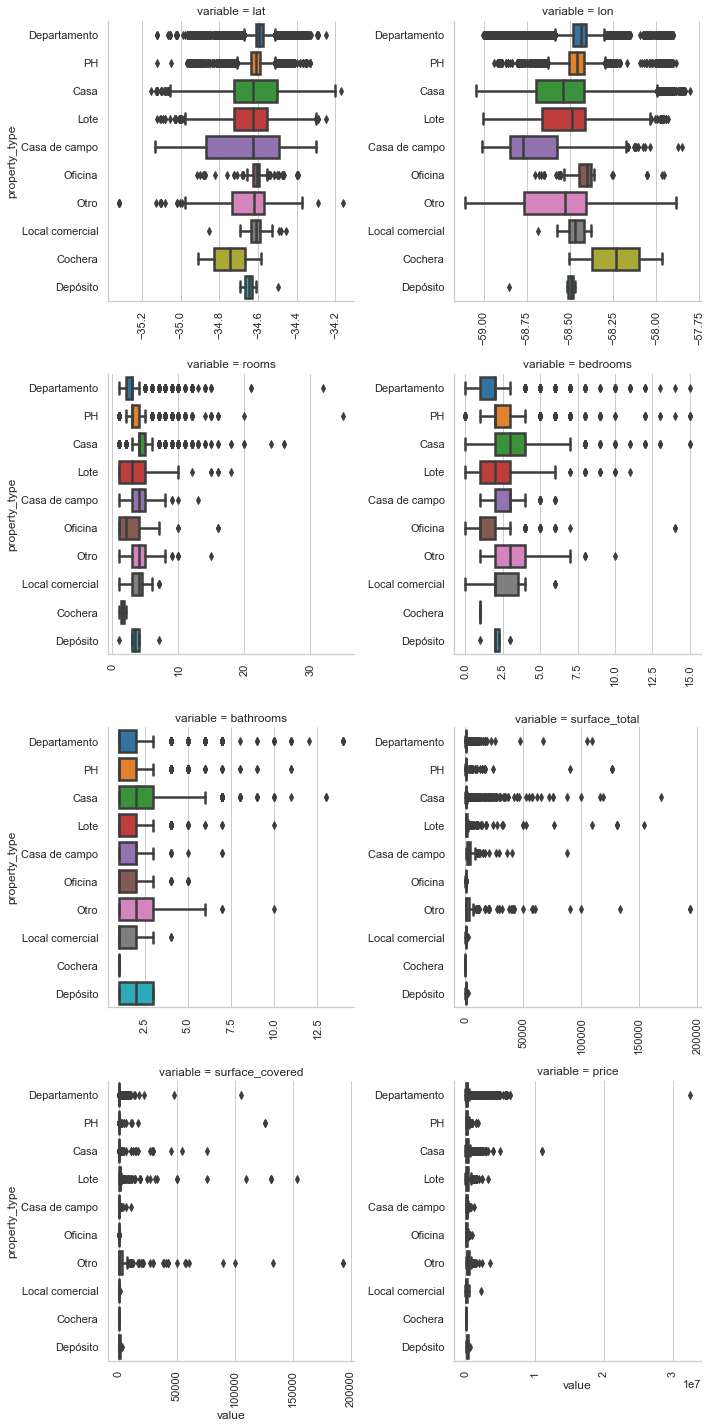

In [21]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(prop, id_vars = ['property_type'], value_vars = quantitative)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 2, sharex = False, sharey = False, height = 5)
g = g.map(boxplot, "value", 'property_type')

In [22]:
columns = ['price','surface_total','surface_covered']
for i in columns:
    q1 = prop[i].quantile(0.25)
    q3 = prop[i].quantile(0.75)
    iqr = q3 - q1
    prop = prop[~((prop[i] < (q1 - 1.5 * iqr)) | (prop[i] > (q3 + 1.5 * iqr)))]
    

In [23]:
prop.shape

(98986, 13)

In [24]:
#z score
from scipy import stats
columns = ['bathrooms','rooms','bedrooms']
for i in columns:
    prop = prop[((prop[i] - prop[i].mean()) / prop[i].std()).abs() < 3]

In [25]:
prop.shape

(96663, 13)

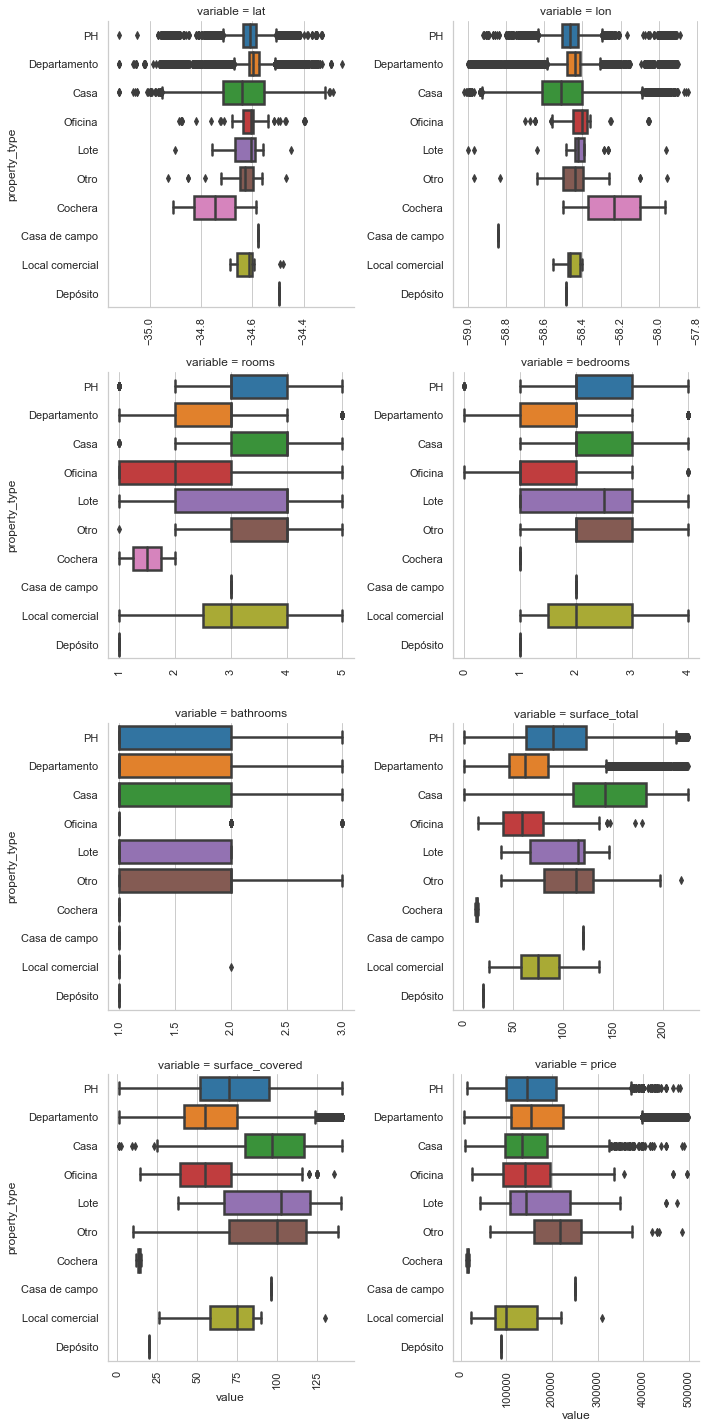

In [26]:
e = pd.melt(prop, id_vars = ['property_type'], value_vars = quantitative)
h = sns.FacetGrid(e, col = "variable",  col_wrap = 2, sharex = False, sharey = False, height = 5)
h = h.map(boxplot, "value", 'property_type')

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

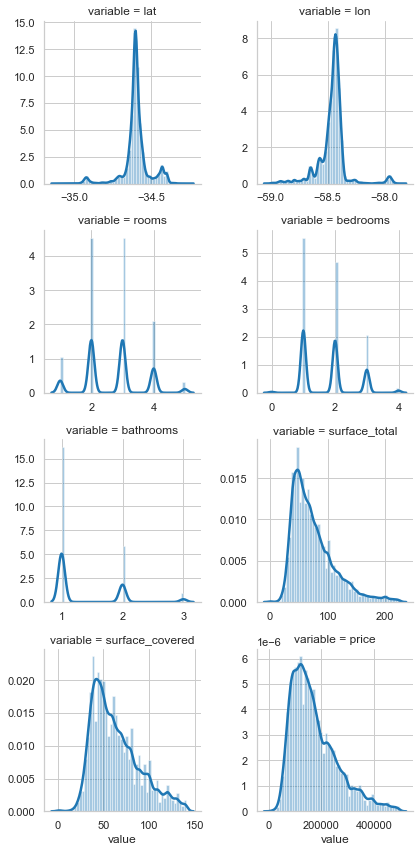

In [27]:
# Credits to Dominik Gawlik in Kaggle: https://www.kaggle.com/dgawlik/house-prices-eda
f = pd.melt(prop, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

### Conclusiones

Por el análisis anterior creo conveniente incurrir a un modelo avanzado de imputación, ya que no tengo suficiente información para conocer la causa por la cual están faltando, y de esa manera también reduciré los faltantes en las columnas de superficie y ubicación, ya que son datos importantes para el modelo. Por las correlaciones que se presentan, podremos deducir los faltantes gracias a otras variables.

<AxesSubplot:>

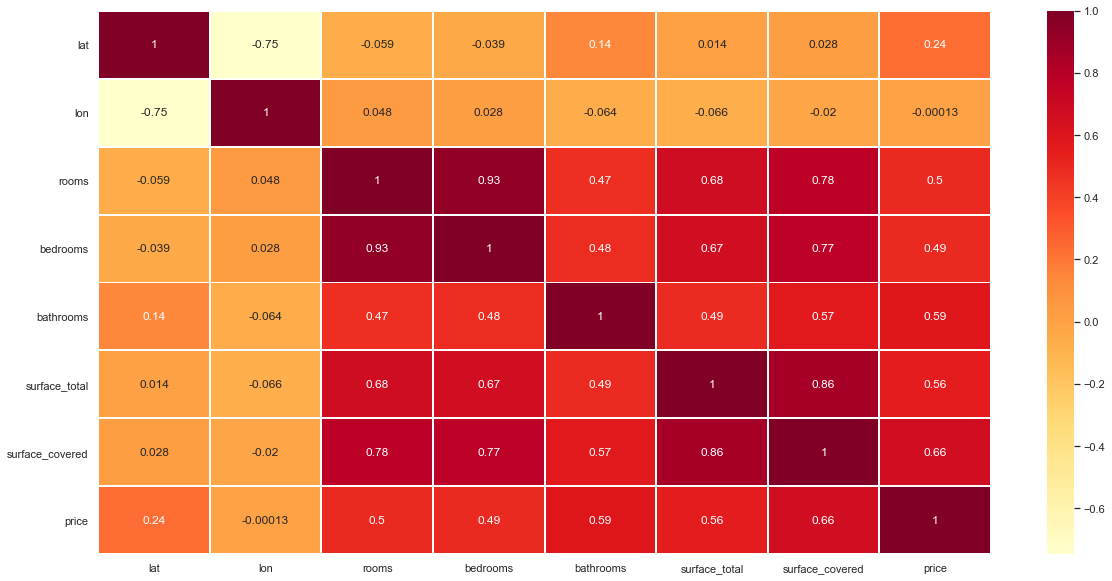

In [28]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(prop.corr(method='pearson'), annot = True, cmap = 'YlOrRd',linewidth = 1, ax = ax)

### **Multivariate feature imputation - Multivariate imputation by chained equations (MICE)**
Decidí usar este modelo porque encuentro bastantes relaciones lineales, y este modelo utiliza la regresión para imputar valores faltantes.

In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
mice = prop.copy(deep = True)

cols = ['lat','lon','bathrooms','surface_total','surface_covered']

mice_imputer = IterativeImputer()

for i in cols:
    mice[i] = mice_imputer.fit_transform(mice[[i]])

In [30]:
missing= missing_values_table(mice)
missing

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

### Guardo el dataset sin valores faltantes ni outliers para continuar 

In [31]:
# Credits to Mariano & Gaspar
mice.to_csv('properati_mice.csv',index=False)
mice_prop = pd.read_csv('properati_mice.csv')

###  **Preguntas sobre los datos estadísticos relevantes**

Desplegaremos varios gráficos para analizar las variables, las relaciones entre sí, sus distribuciones y responderemos a preguntas sobre los datos. En el gráfico resultante de la eliminación de outliers podemos divisar que los precios están distribuidos de manera muy parecida entre las tres categorías mayoritarias, con la diferencia de que algunos tipos de propiedades, como las casas, cuentan con más superficie. Los departamentos se quedan un poco atrás en cuanto a número de cuartos y dormitorios.


### 1. ¿Cuáles son los tipos de propiedad más registrados?

Ordenamos los datos según el tipo de propiedad para analizar la distribución. Notamos que hay 3 categorías mayoritarias y podemos dispensar del resto.

In [32]:
# Se agrupan los datos según el tipo de propiedad, en orden de mayor a menor 
prop_count = mice_prop.groupby(['property_type'], sort = True).size().reset_index()
prop_count.rename(columns = {'property_type' : 'Tipo de propiedad', 0 : 'Cantidad'}, inplace = True)
prop_count = prop_count.sort_values(by = 'Cantidad', ascending = False).reset_index()
prop_count.drop('index', axis = 1, inplace=True)
prop_count

Tipo de propiedad  Cantidad
0      Departamento     81677
1                PH     11220
2              Casa      3352
3           Oficina       326
4              Otro        47
5              Lote        26
6   Local comercial        11
7           Cochera         2
8     Casa de campo         1
9          Depósito         1

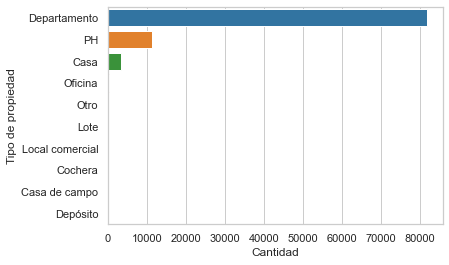

In [33]:
sns.barplot(x= 'Cantidad', y = 'Tipo de propiedad', data = prop_count)
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2.5})

Eliminamos aquellos datos que estén fuera de las categorías mayoritarias.

In [34]:
filter_list = ['Departamento', 'Casa', 'PH']
mice_prop = mice_prop[(mice_prop.property_type.isin(filter_list))]

### 2. ¿Cómo se distribuyen los inmuebles según las zonas y los barrios?

Ahora agrupamos según los barrios y los distritos.

In [35]:
l3_count = mice_prop.groupby(['l2','l3'], sort=True).size().reset_index()
l3_count.rename(columns = {'l2' : 'Distrito', 'l3' : 'Barrio', 0 : 'Count'}, inplace=True)
l3_count = l3_count.sort_values(by = 'Count', ascending = False).reset_index()
l3_count.drop('index', axis = 1, inplace = True)
l3_count

Distrito            Barrio  Count
0            Capital Federal           Palermo   9868
1   Bs.As. G.B.A. Zona Norte             Tigre   6839
2            Capital Federal           Almagro   6426
3            Capital Federal      Villa Crespo   5587
4            Capital Federal         Caballito   4959
..                       ...               ...    ...
84    Bs.As. G.B.A. Zona Sur       San Vicente     15
85    Bs.As. G.B.A. Zona Sur          Cañuelas     13
86  Bs.As. G.B.A. Zona Oeste        Marcos Paz      6
87           Capital Federal         Catalinas      4
88    Bs.As. G.B.A. Zona Sur  Presidente Perón      4

[89 rows x 3 columns]

In [36]:
l2_count= mice_prop.groupby(['l2'], sort=True).size().reset_index()
l2_count.rename(columns = {'l2' : 'Distrito', 0 : 'Count'}, inplace=True)
l2_count = l2_count.sort_values(by = 'Count', ascending = False).reset_index()
l2_count.drop('index', axis = 1, inplace = True)
l2_count

Distrito  Count
0           Capital Federal  68475
1  Bs.As. G.B.A. Zona Norte  15686
2    Bs.As. G.B.A. Zona Sur   6595
3  Bs.As. G.B.A. Zona Oeste   5493

<BarContainer object of 89 artists>

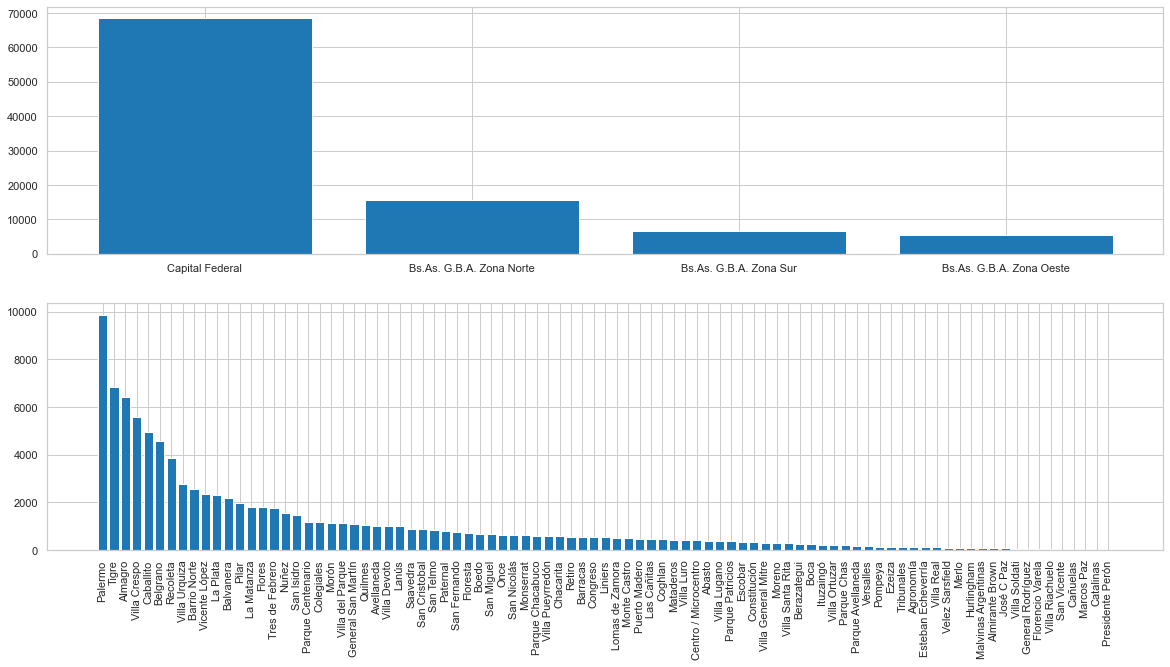

In [37]:
fig,axes = plt.subplots(2,1, figsize = (20,10))
plt.xticks(rotation = 90)
axes[0].bar(l2_count['Distrito'], l2_count['Count'])
axes[1].bar(l3_count['Barrio'], l3_count['Count'])

### 3. ¿Cómo se distribuyen las variables numéricas según el distrito?
Graficamos unos boxplots para ver si varían tanto entre distritos y conviene separar los datos. Notamos que en algunos casos el precio es mayor pero la superficie es menor (Zona Oeste y Sur vs. Capital y Zona Norte, y el resto de las variables comparten más o menos la misma distribución.

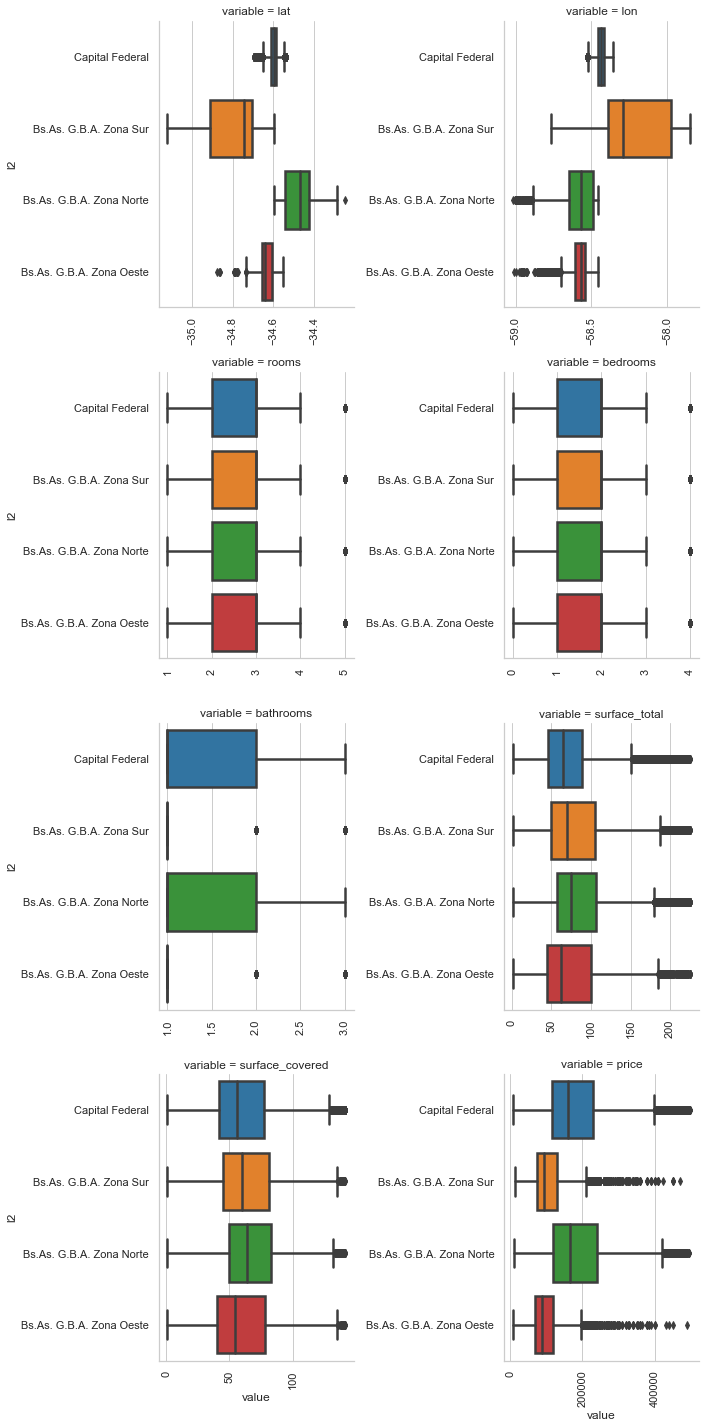

In [38]:
j = pd.melt(mice_prop, id_vars=['l2'], value_vars=quantitative)
k = sns.FacetGrid(j, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
k = k.map(boxplot, "value", 'l2')

### 4. ¿En qué barrio es más caro el metro cuadrado?

Puerto Madero es el barrio que tiene el precio más alto por metro cuadrado.

In [39]:
# Valor promedio del metro cuadrado en cada barrio mostrado en una tabla
mice_prop['m2'] = mice_prop['price'] / mice_prop['surface_total']
pivot_prop = mice_prop.pivot_table(values = 'm2', index = ['l3'], aggfunc=np.mean,fill_value=0)

# Ordenado por precios de departamentos de mayor a menor
pivot_prop.reindex(pivot_prop.sort_values(by = 'm2', ascending = False, inplace= True))
pivot_prop.reset_index(inplace = True)
pivot_prop

l3           m2
0         Puerto Madero  5203.734328
1         Villa Urquiza  4044.923261
2             Agronomía  3777.863997
3           Parque Chas  3720.690410
4           Las Cañitas  3475.345443
..                  ...          ...
84           Marcos Paz  1154.755798
85           Hurlingham  1031.421380
86  Malvinas Argentinas   972.242955
87        Villa Soldati   901.416624
88           José C Paz   854.805732

[89 rows x 2 columns]

<AxesSubplot:xlabel='l3', ylabel='m2'>

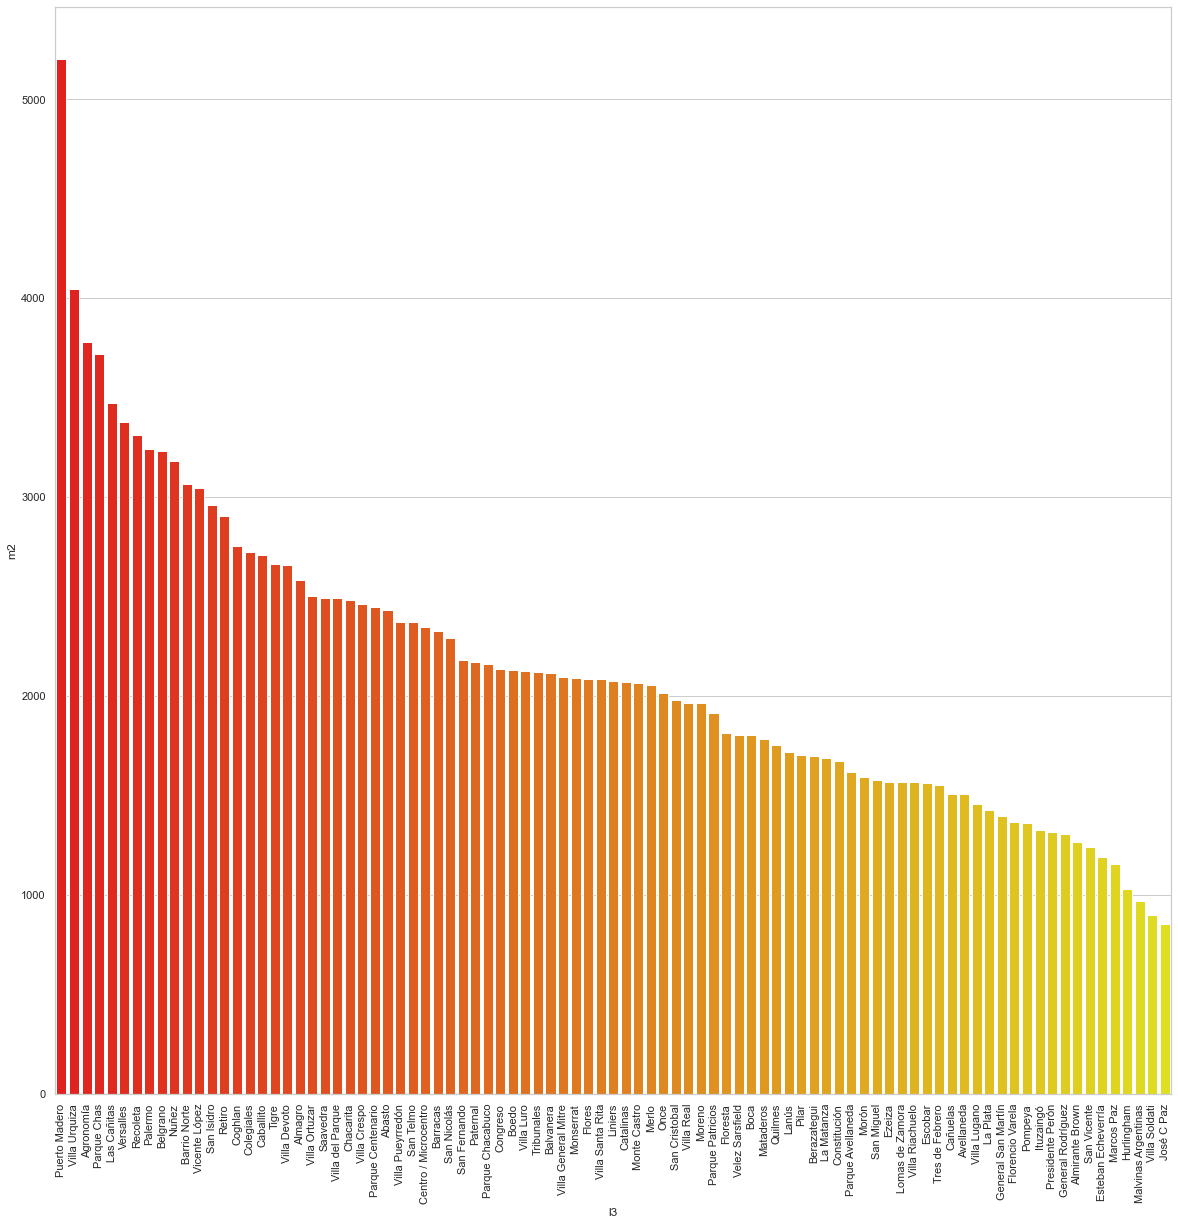

In [40]:
# Puerto Madero tiene el m2 mas caro y Villa Soldati el mas barato
plt.figure(figsize =(20,20))
plt.xticks(rotation = 90)
sns.barplot(y = 'm2', x = 'l3', data = pivot_prop, orient = 'v', ci = 'sd', palette = 'autumn')

### 5. ¿Cómo se distribuyen los tipos de propiedad según el distrito?

<AxesSubplot:xlabel='count', ylabel='l2'>

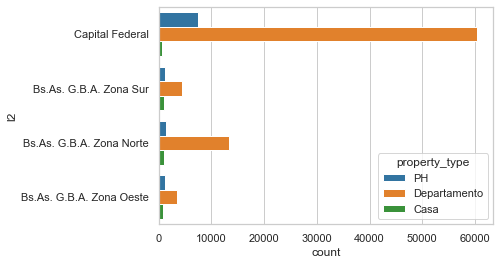

In [41]:
# Comparativa segun tipo de inmuebles y cantidad
sns.countplot(y = 'l2', data = mice_prop, hue = 'property_type')

Notamos que los departamentos son el tipo de propiedad con mayor cantidad de registros en todos los distritos.
Creo conveniente separarlos del resto de los casos para el análisis, ya que seguramente incidan de manera distinta las variables para cada tipo de propiedad, más allá del distrito.

Por un lado sabemos que los precios se encuentran distribuidos de manera similar, por lo que extraer los datos de las casas y PHs no van a cambiar la variable respuesta. En cambio, si solo tomamos los departamentos, notaremos diferencias de precios según los distritos

Vamos a comprobar dos hipótesis para limpiar los datos nuevamente para obtener un mejor modelo. Por un lado, evaluaremos los departamentos en todos los distritos, y por otro lado, todos los tipos de inmueble en Capital Federal.

In [42]:
dep_prop= mice_prop[mice_prop['property_type']=='Departamento']
cap_prop= mice_prop[mice_prop['l2']=='Capital Federal']

In [43]:
print(dep_prop.shape)
print(cap_prop.shape)

(81677, 14)
(68475, 14)


No son suficientes datos, vamos a continuar con mice_prop y hacer encoding de variables.

### 6. ¿Qué variable es más representativa?

Hacemos un pairplot para ver cómo quedaron los datos y si podemos deducir algo más. Notamos también una fuerte correlación entre superficie total y superficie cubierta. Vemos que latitud y longitud tienen cierta relación con el precio por metro cuadrado, quizás podamos encontrar algo más cuando hagamos clustering.

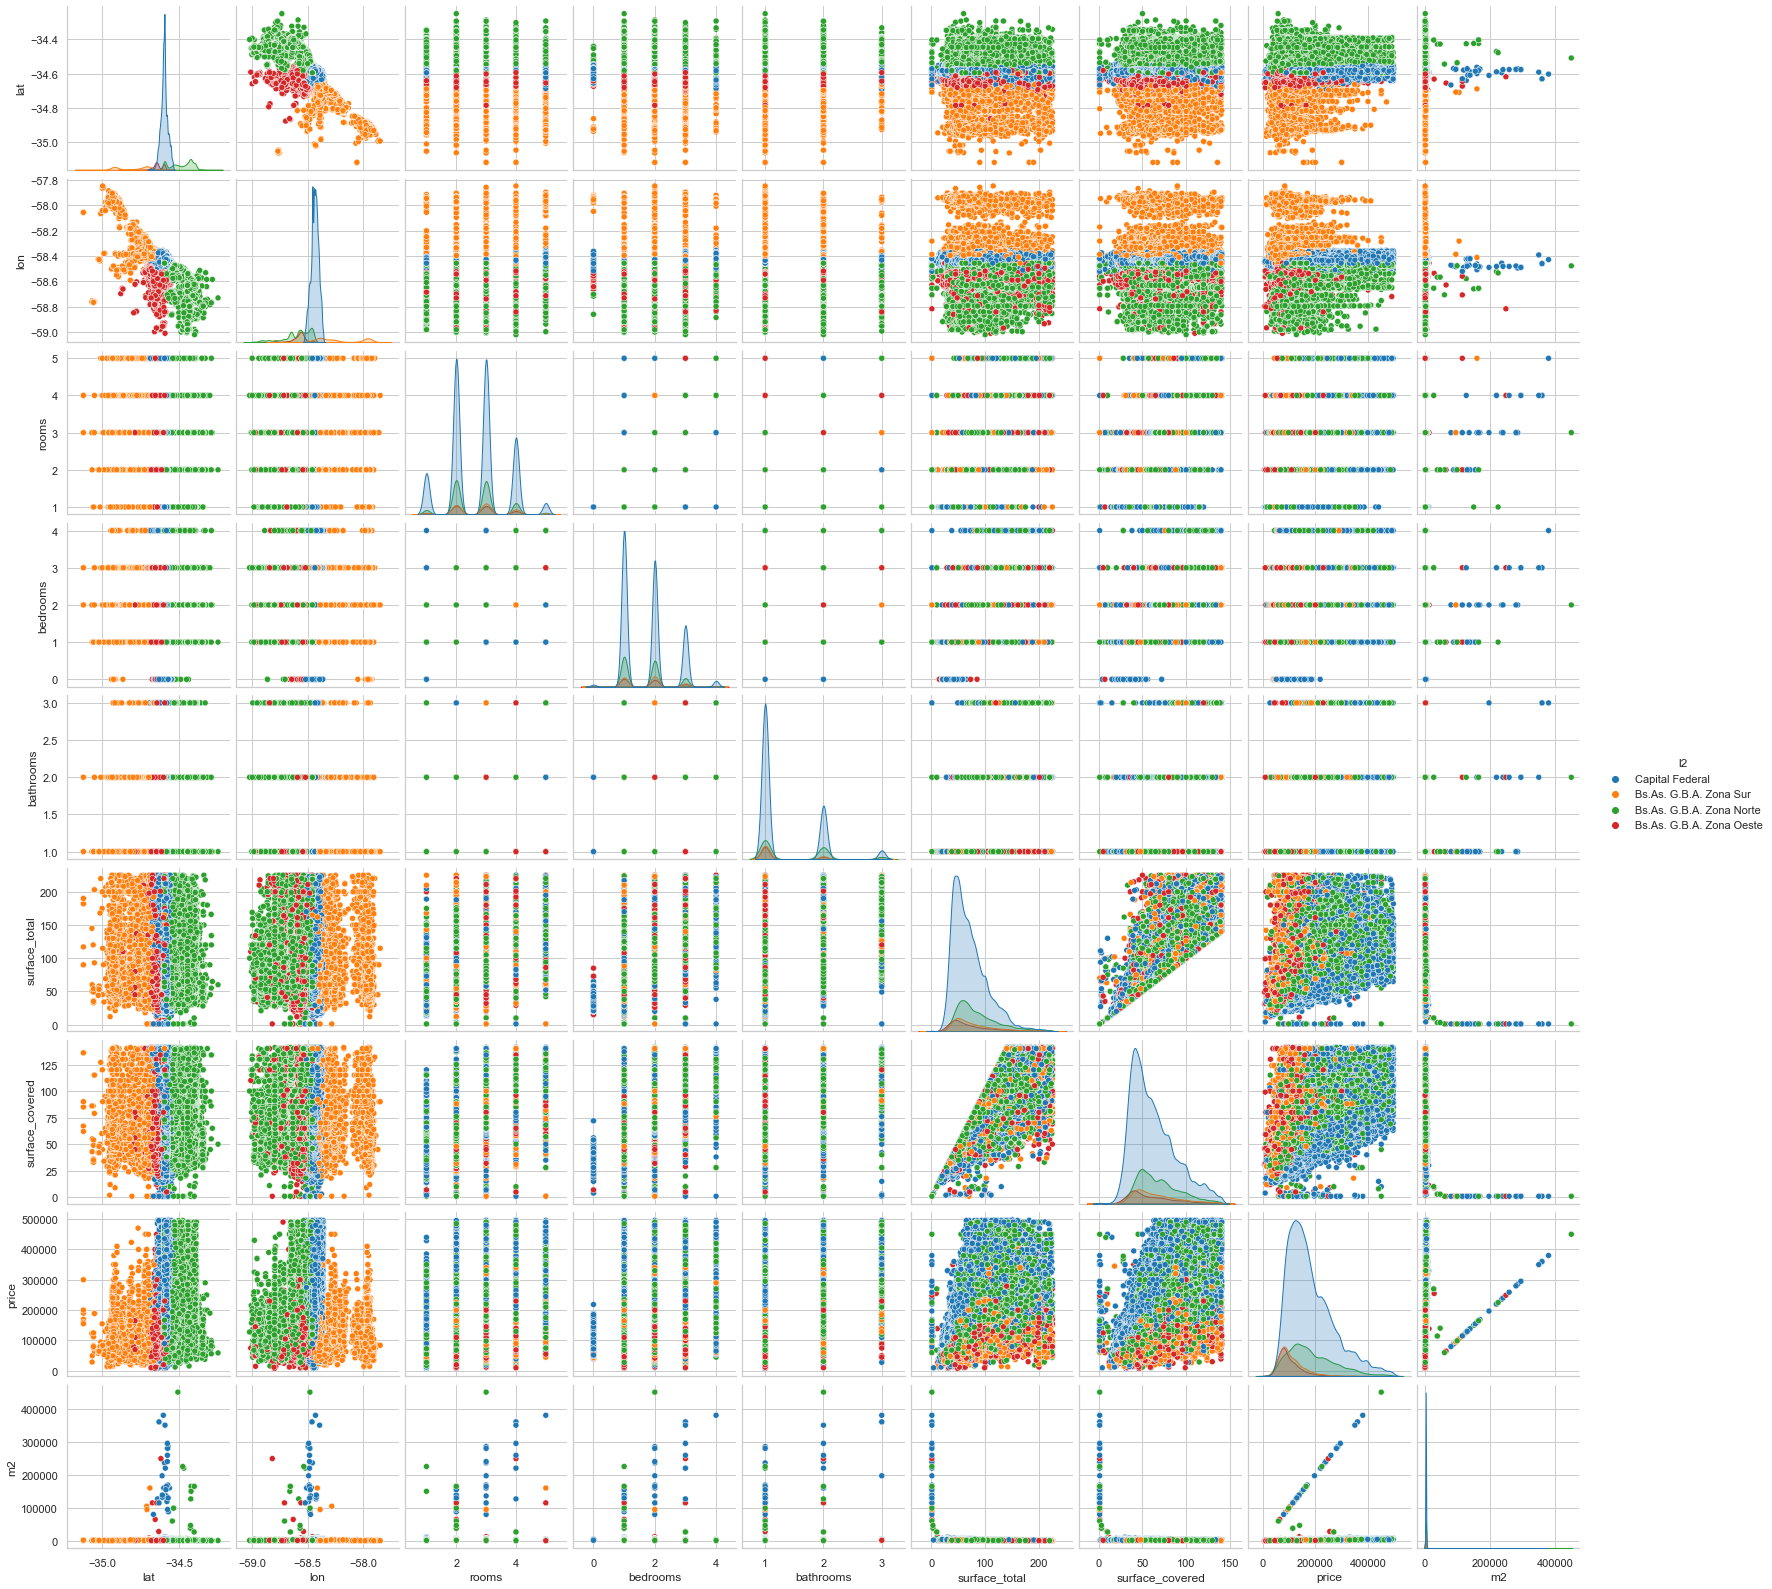

In [44]:
sns.pairplot(mice_prop, hue= 'l2')

### Correlaciones

La correlación de Spearman es mejor para trabajar en estos casos porque puede captar relaciones entre variables incluso si no son lineales. La superficie y los baños parecen ser las variables que más influye en el precio, junto con los cuartos y los dormitorios. Vemos también que los distritos tienen cierta influencia, bastante más que el tipo de propiedad. La latitud es sorpresa, pero suponemos que es porque las viviendas ubicadas más al norte son las de los barrios más caros.

In [45]:
quantitative = [f for f in mice_prop.columns if mice_prop.dtypes[f] != 'object']
qualitative = [f for f in mice_prop.columns if mice_prop.dtypes[f] == 'object']

In [46]:
quantitative.remove('price')
qualitative.remove('description')
qualitative.remove('title')

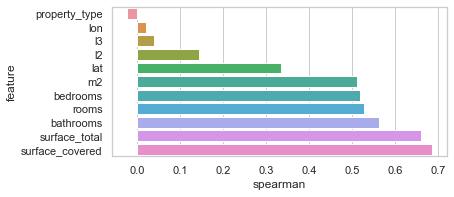

In [47]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['price'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qualitative
spearman(mice_prop, features)

### **Encoding**

La columna categórica más interesante para aplicar one-hot encoding es la de distritos. Vamos a transformarla junto con la de tipos de propiedad, y luego veremos cuales serán más importantes para el modelo. Eliminamos las columnas que son redundantes a estas alturas.

In [48]:
# Creo nuevas variables a partir de la columna property_type
mice_enc = pd.concat([mice_prop, pd.get_dummies(mice_prop['l2'], drop_first=True)], axis = 1)
mice_enc = pd.concat([mice_enc, pd.get_dummies(mice_prop['property_type'], drop_first=True)], axis = 1)
# Elimino la variable de tipo de propiedad para analizar el conjunto de propiedades

In [49]:
mice_enc.head(2)

lat        lon               l2       l3  rooms  bedrooms  bathrooms  \
0 -34.624056 -58.412110  Capital Federal    Boedo    2.0       1.0        2.0   
1 -34.593569 -58.427474  Capital Federal  Palermo    2.0       1.0        1.0   

   surface_total  surface_covered     price  \
0           70.0             58.0  159000.0   
1           45.0             45.0  125000.0   

                                               title  \
0   Espectacular PH reciclado en Boedo sin expensas.   
1  Depto.tipo casa de 2 ambientes en Venta en Pal...   

                                         description property_type  \
0   PH reciclado en Boedo a una cuadra de la plaz...            PH   
1  2 ambienets amplio , excelente estado , patio ...            PH   

            m2  Bs.As. G.B.A. Zona Oeste  Bs.As. G.B.A. Zona Sur  \
0  2271.428571                         0                       0   
1  2777.777778                         0                       0   

   Capital Federal  Departamento  PH  
0                1             0   1  
1                1             0   1

### **Generación de nuevas variables predictoras**

Vamos a modificar las variables que vemos que se solapan, y que podrían estar definidas de otra manera.
Vemos que las superficies estan muy relacionadas, por lo definiremos superficie total y superficie descubierta, mediante la sustracción de ambas.

También fusionaremos la variable cuartos con dormitorios porque están muy relacionadas entre sí y sabemos que no hay muchas diferencias en cuanto a características (en cambio, si existen diferencias con los baños).

In [50]:
new_prop = mice_enc.copy()
new_prop['surface_uncovered'] = new_prop['surface_total'] - new_prop['surface_covered']
new_prop['rooms'] = new_prop['rooms'] + new_prop['bedrooms']

new_prop = new_prop.drop(['surface_covered','bedrooms'],axis = 1)

Notamos que el encoding sobre la variable de distrito l2 fue acertado y tiene influencia sobre el precio. No tanto con el encoding de la variable de tipo de propiedad.

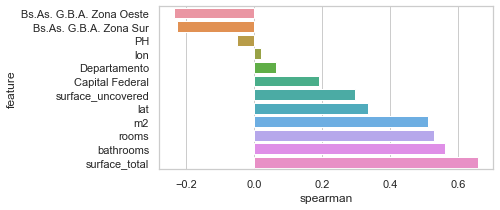

In [51]:
quantitative = [f for f in new_prop.columns if new_prop.dtypes[f] != 'object']
quantitative.remove('price')
features = quantitative
spearman(new_prop, features)

### **Transformación logarítmica**

Revisamos cómo quedaron las distribuciones de las variables y si tienen algun sesgo. Quitamos las variables encodeadas

In [52]:
quantitative = [f for f in new_prop.columns if new_prop.dtypes[f] != 'object']
qualitative = [f for f in new_prop.columns if new_prop.dtypes[f] == 'object']
quantitative.remove('Bs.As. G.B.A. Zona Oeste')
quantitative.remove('Bs.As. G.B.A. Zona Sur')
quantitative.remove('Capital Federal')
quantitative.remove('Departamento')
quantitative.remove('PH')

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

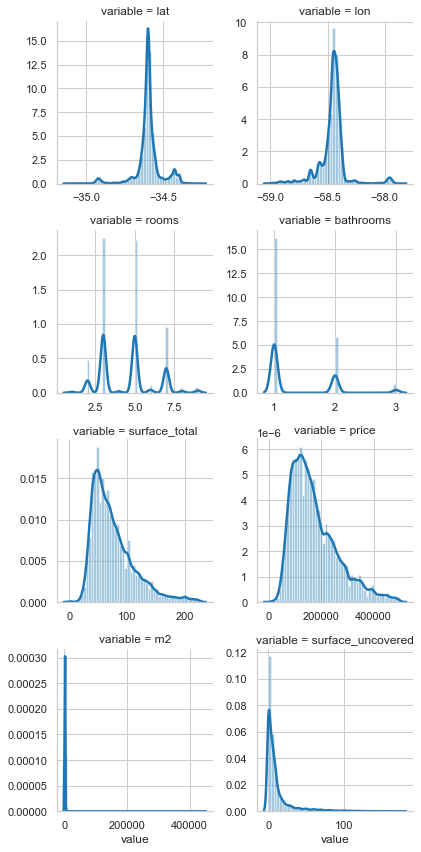

In [53]:
# Credits to Dominik Gawlik in Kaggle: https://www.kaggle.com/dgawlik/house-prices-eda
f = pd.melt(new_prop, value_vars = quantitative)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 2, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

Vemos que las demas variables cuantitativas, ninguna tiene una distribución normal, pero no va a ser posible aplicarles la transformación, excepto las superficies, que muestran una distribución normal de cola larga.

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

Skewness:
1.0745746658755366
Kurtosis:
0.8923638345590654


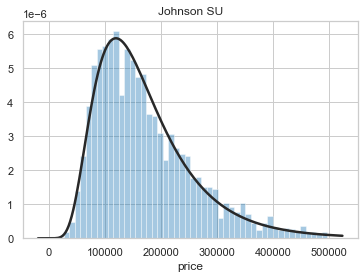

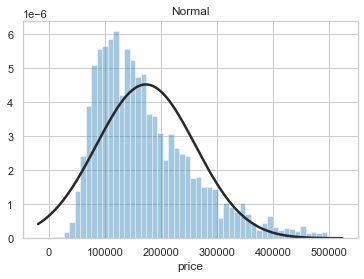

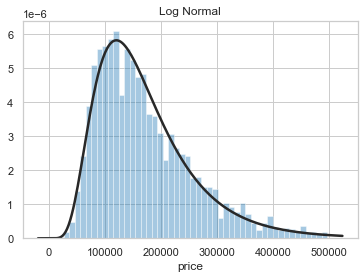

In [54]:
# Credits to Dominik Gawlik in Kaggle: https://www.kaggle.com/dgawlik/house-prices-eda
import scipy.stats as st
y = new_prop['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)
print(f'Skewness:')
print(new_prop['price'].skew())
print(f'Kurtosis:') 
print(new_prop['price'].kurt())


Vemos que la distribución de la variable respuesta tiene un sesgo positivo, lo que significa que muchas casas se están vendiendo a un precio menor al promedio. Tanto Johnson como la logarítmica se adaptan bien a la distribución.

C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 173216.63 and sigma = 88197.32



C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 11.94 and sigma = 0.50



Text(0.5, 0.98, 'Después de la transformación')

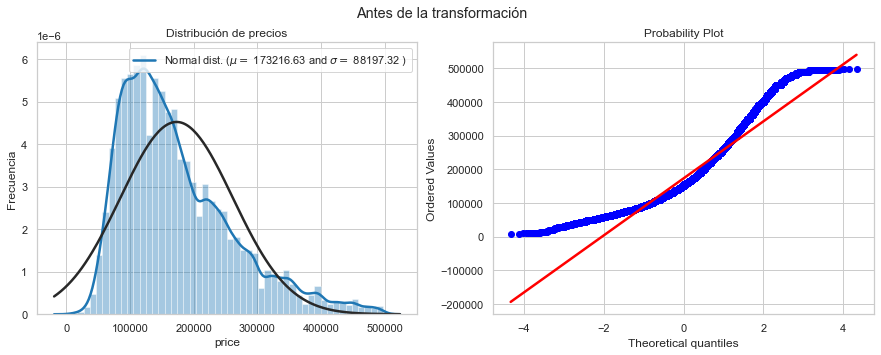

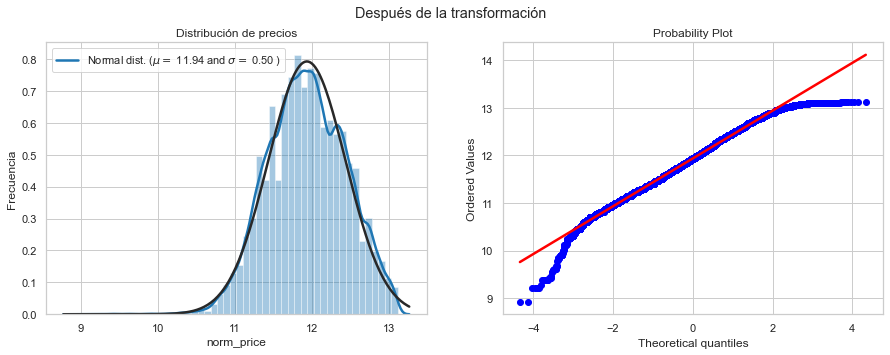

In [55]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(new_prop['price'] , fit=norm);
(mu, sigma) = norm.fit(new_prop['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.subplot(1,2,2)
res = stats.probplot(new_prop['price'], plot=plt)
plt.suptitle('Antes de la transformación')

# Apply transformation
new_prop['norm_price'] = np.log1p(new_prop.price )
# New prediction
y_train = new_prop.price.values
y_train_orig = new_prop.price


# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(new_prop['norm_price'] , fit=norm);
(mu, sigma) = norm.fit(new_prop['norm_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
plt.ylabel('Frecuencia')
plt.title('Distribución de precios')
plt.subplot(1,2,2)
res = stats.probplot(new_prop['norm_price'], plot=plt)
plt.suptitle('Después de la transformación')



In [56]:
new_prop.head(2)

lat        lon               l2       l3  rooms  bathrooms  \
0 -34.624056 -58.412110  Capital Federal    Boedo    3.0        2.0   
1 -34.593569 -58.427474  Capital Federal  Palermo    3.0        1.0   

   surface_total     price                                              title  \
0           70.0  159000.0   Espectacular PH reciclado en Boedo sin expensas.   
1           45.0  125000.0  Depto.tipo casa de 2 ambientes en Venta en Pal...   

                                         description property_type  \
0   PH reciclado en Boedo a una cuadra de la plaz...            PH   
1  2 ambienets amplio , excelente estado , patio ...            PH   

            m2  Bs.As. G.B.A. Zona Oeste  Bs.As. G.B.A. Zona Sur  \
0  2271.428571                         0                       0   
1  2777.777778                         0                       0   

   Capital Federal  Departamento  PH  surface_uncovered  norm_price  
0                1             0   1               12.0   11.976666  
1                1             0   1                0.0   11.736077

### **Escalado de datos**

Vamos a regularizar para eliminar cualquier rastro de multicolinealidad. Vemos en el heatmap las variables de superficies siguen estando bastante relacionadas entre sí. Primero vamos a redefinir nuestras variables cuantitativas para el modelo de Machine Learning. Conservaremos ambos datasets para comparar posteriormente los rendimientos en los modelos de aprendizaje.

<AxesSubplot:>

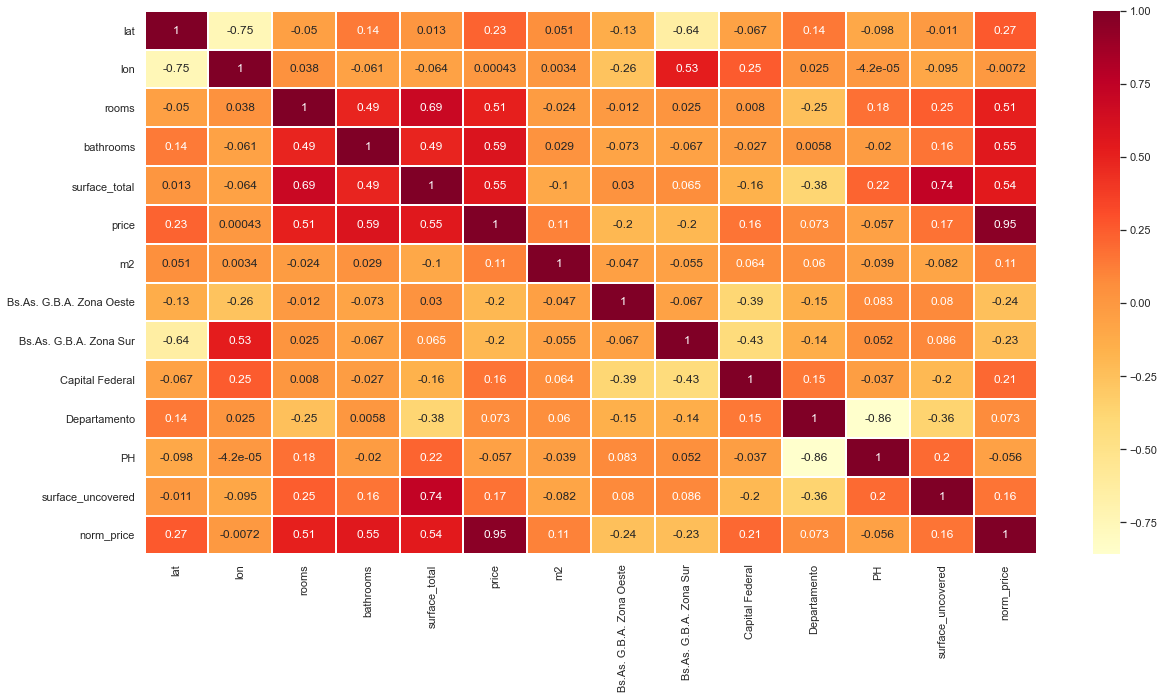

In [57]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(new_prop.corr(method='pearson'), annot = True, cmap = 'YlOrRd',linewidth = 1, ax = ax)

In [58]:
quantitative.remove('price')
quant_prop = new_prop[quantitative]

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
scaler= StandardScaler()

In [61]:
regularized= scaler.fit_transform(quant_prop)

In [62]:
scaled_prop = pd.DataFrame(regularized, index = quant_prop.index, columns = quant_prop.columns)
scaled_prop

lat       lon     rooms  bathrooms  surface_total        m2  \
0     -0.356283  0.376299 -0.847288   1.204592      -0.133281 -0.057783   
1      0.019321  0.247153 -0.847288  -0.607946      -0.817739  0.044714   
2      0.170551  0.169145 -0.847288  -0.607946       0.277394  0.184954   
3     -3.930868  4.359767 -0.847288  -0.607946      -0.680848 -0.355633   
4      0.016733  0.131447 -0.847288  -0.607946      -0.516578  0.024632   
...         ...       ...       ...        ...            ...       ...   
96658 -2.725381  2.310883 -0.847288  -0.607946      -0.571334  0.100942   
96659  1.831760 -4.042665  1.522939   1.204592       2.440282 -0.357114   
96660  1.854252 -4.410811 -1.439845  -0.607946      -0.680848 -0.222034   
96661  1.851825 -4.412408 -0.847288  -0.607946      -1.009388 -0.155341   
96662  1.852696 -4.413160  0.337826  -0.607946       0.003611 -0.253072   

       surface_uncovered  
0               0.029601  
1              -0.584745  
2               1.207098  
3               0.183188  
4              -0.584745  
...                  ...  
96658          -0.277572  
96659           3.203724  
96660           0.183188  
96661          -0.584745  
96662          -0.584745  

[96249 rows x 7 columns]

### Combinamos los datos escalados con los encodings y la variable respuesta

In [63]:
not_scaled = new_prop[['Bs.As. G.B.A. Zona Oeste','Bs.As. G.B.A. Zona Sur',
                       'Capital Federal','Departamento','PH','norm_price']]
not_scaled.head(2)

Bs.As. G.B.A. Zona Oeste  Bs.As. G.B.A. Zona Sur  Capital Federal  \
0                         0                       0                1   
1                         0                       0                1   

   Departamento  PH  norm_price  
0             0   1   11.976666  
1             0   1   11.736077

In [64]:
ml_prop = pd.concat([scaled_prop,not_scaled], axis = 1)
ml_prop.head(2)

lat       lon     rooms  bathrooms  surface_total        m2  \
0 -0.356283  0.376299 -0.847288   1.204592      -0.133281 -0.057783   
1  0.019321  0.247153 -0.847288  -0.607946      -0.817739  0.044714   

   surface_uncovered  Bs.As. G.B.A. Zona Oeste  Bs.As. G.B.A. Zona Sur  \
0           0.029601                         0                       0   
1          -0.584745                         0                       0   

   Capital Federal  Departamento  PH  norm_price  
0                1             0   1   11.976666  
1                1             0   1   11.736077

In [65]:
missing = missing_values_table(ml_prop)
missing

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

### Guardamos el dataset

In [66]:
# Credits to Mariano & Gaspar
ml_prop.to_csv('ml_prop.csv',index=False)
scaled_prop.to_csv('scaled_prop.csv',index=False)

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2.5})

In [68]:
ml_prop = pd.read_csv('ml_prop.csv')

In [69]:
ml_prop.shape

(96249, 13)

Dividimos los datos

In [70]:
X= ml_prop.drop(['norm_price','m2'], axis = 1)
y= ml_prop.norm_price

### **Clustering**

Importamos librerías de clusterización.

In [71]:
from sklearn.cluster import KMeans

In [72]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
Sum_of_squared_distances = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
K = np.arange(1,len(X.columns)+1)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X.shape[0])
    Sum_of_squared_distances.append(distancia_media)

Text(0.5, 1.0, 'Método del codo para el Dataset 1')

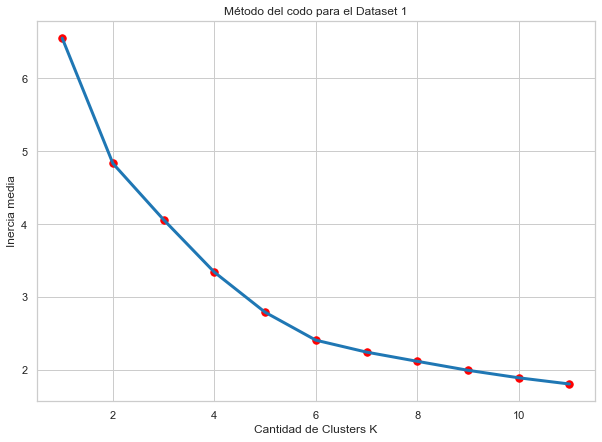

In [73]:
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset 1')

Probamos en el mapa de coordenadas la clusterización.

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Data points and cluster centroids')

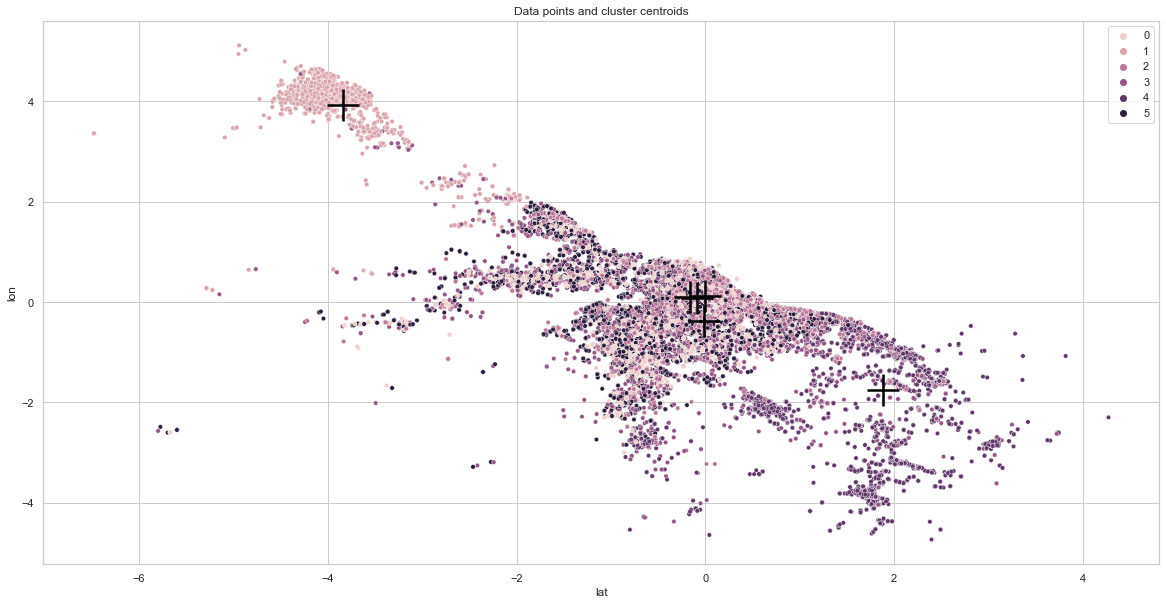

In [74]:
# Defino y entreno el modelo
km = KMeans(n_clusters = 6)
km = km.fit(X)
# Obtengo la posición de los centros y las etiquetas
etiquetas_ = km.labels_
centros_ = km.cluster_centers_
# Plotting the cluster centers and the data points on a 2D plane
fig, ax = plt.subplots(figsize = (20,10))
sns.scatterplot(ml_prop['lat'], ml_prop['lon'], hue = etiquetas_, s = 20)
sns.scatterplot(centros_[:, 0], centros_[:, 1],color='black', marker="+", s=1000)
plt.title('Data points and cluster centroids')

### **Reducción de dimensionalidad (PCA)**

Al igual que la clusterización, vamos a ver que información extra podemos conseguir del PCA. Como vemos en las correlaciones, hay variables relacionadas entre si que serían útiles para un modelo de regresión.

<AxesSubplot:>

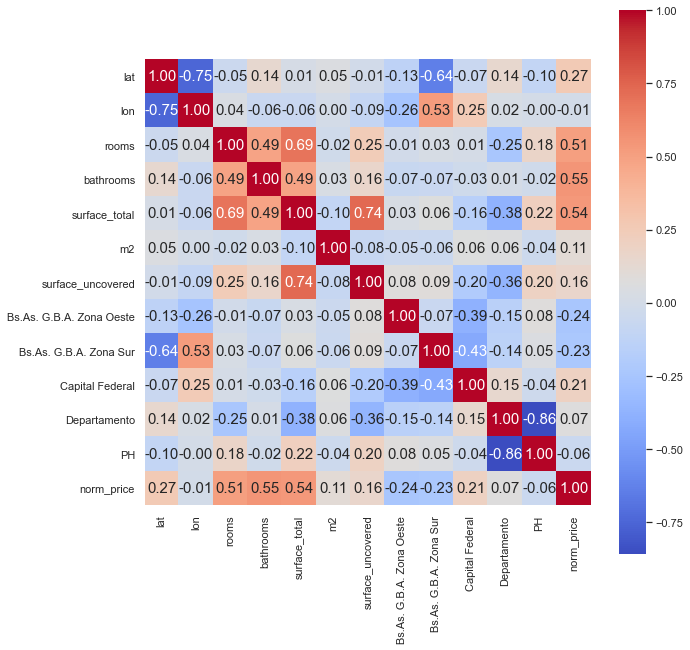

In [75]:
corr = ml_prop.corr(method='pearson') # .corr is used for find corelation
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= ml_prop.columns, 
           yticklabels= ml_prop.columns,
           cmap= 'coolwarm')

Vemos que porcentaje de la varianza se explica para cada conjunto de componentes.

In [76]:
from sklearn.decomposition import PCA
covar_matrix = PCA(n_components = len(X.columns))
covar_matrix.fit(X)

PCA(n_components=11)

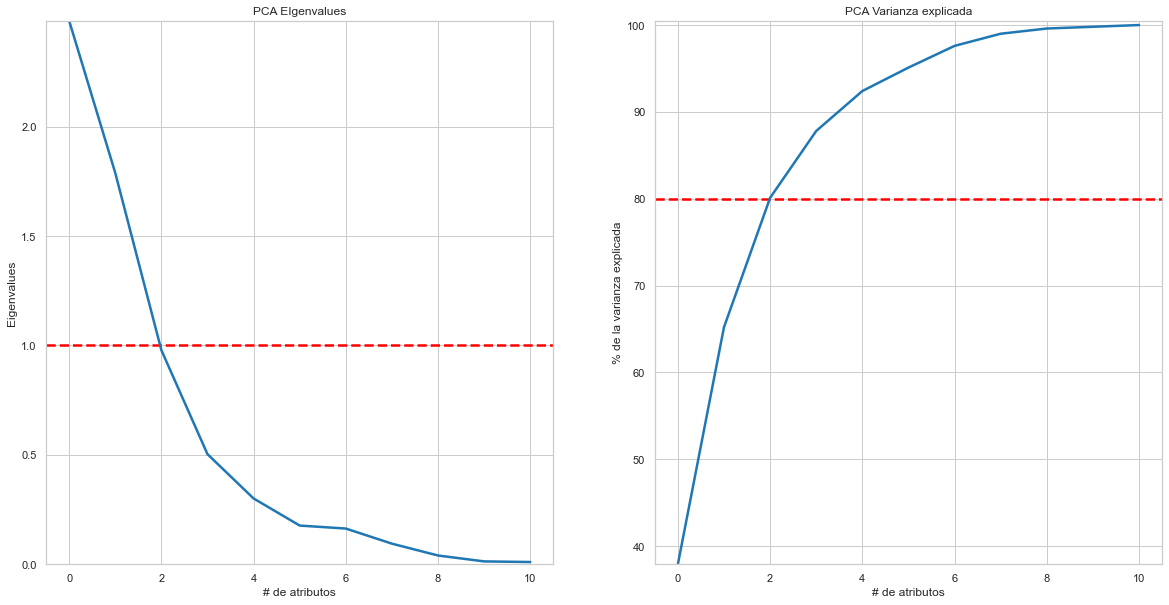

In [77]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.ylabel('Eigenvalues')
plt.xlabel('# de atributos')
plt.title('PCA EIgenvalues')
plt.ylim(0,max(covar_matrix.explained_variance_))
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.plot(covar_matrix.explained_variance_)

variance = covar_matrix.explained_variance_ratio_
var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals = 3)*100)

plt.subplot(1,2,2)
plt.ylabel('% de la varianza explicada')
plt.xlabel('# de atributos')
plt.title('PCA Varianza explicada')
plt.ylim(min(var), 100.5)
plt.axhline(y = 80, color = 'r', linestyle = '--')
plt.plot(var)

Estos gráficos nos muestran cuántos componentes son ideales para tener en cuenta. Tomaremos los componentes que tengan eigenvalues de al menos 1 y también los necesarios para explicar el 80% de la varianza, lo que nos queda en 3 componentes principales.

Veamos gráficamente cómo quedan los dos primeros componentes principales.

### PCA 2D

In [78]:
pca2D = PCA(n_components=2)
x_pca2D = pca2D.fit_transform(X) 

In [79]:
df_comp2D = pd.DataFrame(pca2D.components_, columns=X.columns)

In [80]:
pca2D.components_

array([[ 0.07175668, -0.0994423 ,  0.49086433,  0.41860968,  0.60226469,
         0.44282117,  0.00453476, -0.00247888, -0.04509583, -0.0781049 ,
         0.04250044],
       [-0.69439122,  0.68605254,  0.14035617, -0.03499593,  0.07533327,
         0.0392036 , -0.01258028,  0.11855652,  0.05389335, -0.03599132,
         0.0245433 ]])

El resultado de dividir los datos en los dos componentes principales parece una especie de clustering. Se separan los distritos de más al sur de los más al norte.

0.6519329851176282


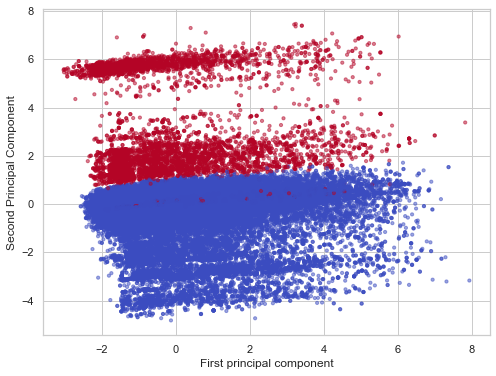

In [81]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca2D[:,0],x_pca2D[:,1], s = 10, c = ml_prop['Bs.As. G.B.A. Zona Sur'], cmap='coolwarm', alpha = 0.5)
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
print(np.sum(pca2D.explained_variance_ratio_))

Vemos que las variables que más influyen en estos componentes son, para el primero, la superficies, cuartos y baños, y para el segundo, latitud y longitud. Los encodings no parecen tener una influencia relevante en los componentes.

<AxesSubplot:>

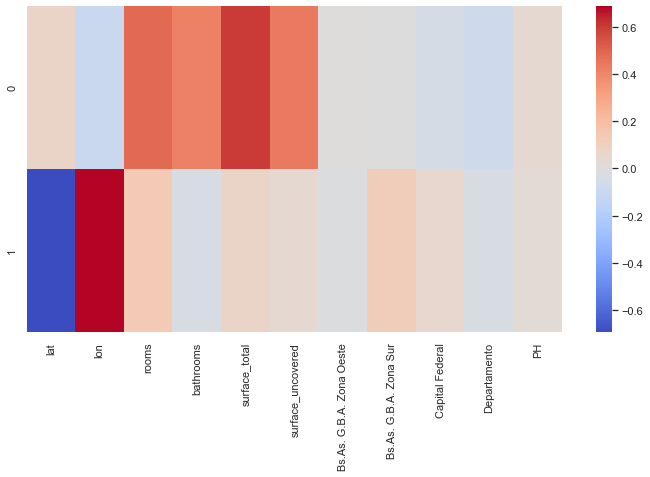

In [82]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp2D,cmap='coolwarm',)

Ahora probamos dividir en sus tres componentes principales.

### PCA 3D

In [83]:
pca3D = PCA(n_components=3)
x_pca3D = pca3D.fit_transform(X) 

In [84]:
df_comp3D = pd.DataFrame(pca3D.components_,columns=X.columns)

In [85]:
pca3D.components_

array([[ 0.07175668, -0.0994423 ,  0.49086433,  0.41860968,  0.60226469,
         0.44282117,  0.00453476, -0.00247888, -0.04509583, -0.0781049 ,
         0.04250044],
       [-0.69439122,  0.68605254,  0.14035617, -0.03499593,  0.07533327,
         0.0392036 , -0.01258028,  0.11855652,  0.05389335, -0.03599132,
         0.0245433 ],
       [-0.08788193, -0.10845875, -0.35319825, -0.58922044,  0.17042601,
         0.66993956,  0.04312324,  0.03442687, -0.10768153, -0.11111924,
         0.06109066]])

0.8012576718687553


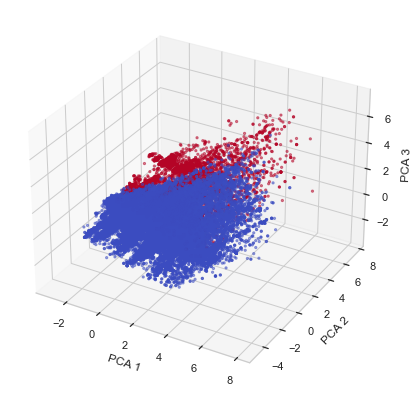

In [86]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(10,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x_pca3D[:,0], x_pca3D[:,1], x_pca3D[:,2], s = 5, c = ml_prop['Bs.As. G.B.A. Zona Sur'],
             cmap='coolwarm', alpha = 0.5 )

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
print(np.sum(pca3D.explained_variance_ratio_))

Los primeros 2 componentes se mantienen relativamente parecidos a cuando aplicamos 2 componentes, y el tercero incluye superficie descubierta.

<AxesSubplot:>

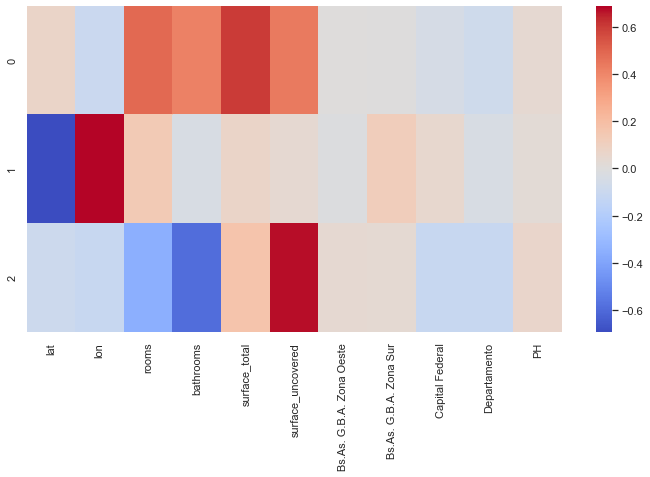

In [87]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp3D,cmap='coolwarm',)

In [88]:
pcax = pd.DataFrame(x_pca3D, columns = ['PCA1','PCA2', 'PCA3'])

## **2. Modelos de aprendizaje**

Importamos las librerias necesarias para evaluar.

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [90]:
%%capture
from tqdm import tqdm
import time
tqdm().pandas()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2.5})

In [91]:
ml_prop = pd.read_csv('ml_prop.csv')
ml_prop.head(2)

lat       lon     rooms  bathrooms  surface_total        m2  \
0 -0.356283  0.376299 -0.847288   1.204592      -0.133281 -0.057783   
1  0.019321  0.247153 -0.847288  -0.607946      -0.817739  0.044714   

   surface_uncovered  Bs.As. G.B.A. Zona Oeste  Bs.As. G.B.A. Zona Sur  \
0           0.029601                         0                       0   
1          -0.584745                         0                       0   

   Capital Federal  Departamento  PH  norm_price  
0                1             0   1   11.976666  
1                1             0   1   11.736077

Dividimos los datos en features y variable respuesta. Utilizamos los componentes principales como X, entonces los convertimos en dataframe.

In [92]:
X = ml_prop.drop(['norm_price','m2'], axis = 1)
y = ml_prop.norm_price

Hacemos un Train-Test split de los datos

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### **Baseline**
Probamos algunos modelos simples y evaluamos su performance

In [94]:
reg1 = LinearRegression()
reg1.fit(X_train, y_train)

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

Loop 1: 0it [00:00, ?it/s]

Modelo: Árbol de Decisión


MAE Train: 0.012934412464805192
MAE Test: 0.11627776596016304
MSE Train: 0.001779089381851371
MSE Test: 0.04864618464778768
RMSE Train: 0.04217925297882089
RMSE Test: 0.22055880088490615




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Loop 1: 1it [00:01,  1.67s/it]

Modelo: Vecinos más cercanos


MAE Train: 0.10853288945696105
MAE Test: 0.13703323679258045
MSE Train: 0.02815824785396862
MSE Test: 0.04444813672877225
RMSE Train: 0.16780419498322627
RMSE Test: 0.21082726751720768




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Loop 1: 2it [00:07,  2.96s/it]

Modelo: Regresión lineal


MAE Train: 0.23009009313175674
MAE Test: 0.2302061783226737
MSE Train: 0.08920464402837947
MSE Test: 0.08983945168899951
RMSE Train: 0.2986714650387269
RMSE Test: 0.2997323000428875




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Loop 1: 3it [00:09,  3.05s/it]


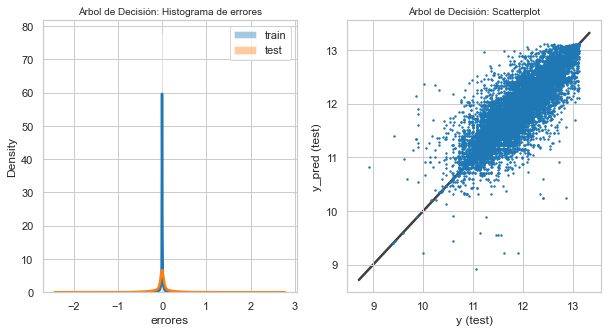

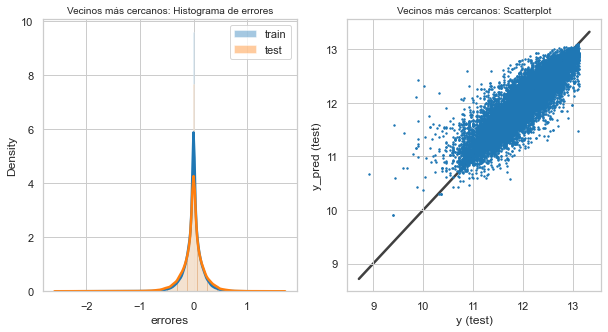

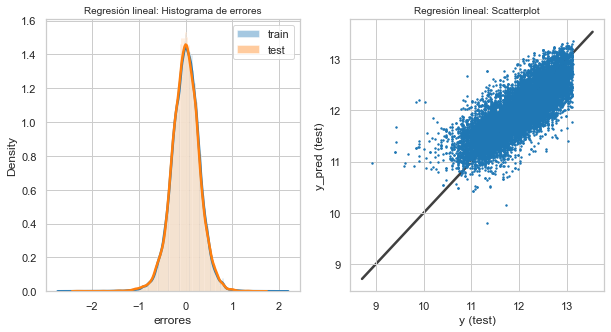

In [95]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos', 'Regresión lineal']

for i, model in tqdm(enumerate([tree, knn, reg1]), desc = 'Loop 1', leave = True):
    time.sleep(0.5)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')
    print('\n')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'MAE Train: {(mean_absolute_error(y_train, y_train_pred))}')
    print(f'MAE Test: {(mean_absolute_error(y_test, y_test_pred))}')
    print(f'MSE Train: {(mean_squared_error(y_train, y_train_pred))}')
    print(f'MSE Test: {(mean_squared_error(y_test, y_test_pred))}')
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Test: {rmse_test}')
    print('\n')
    
    plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    plt.title(f'{modelos[i]}: Histograma de errores', fontsize= 10)
    sns.distplot(y_train - y_train_pred, label = 'train', bins= 200)
    sns.distplot(y_test - y_test_pred, label = 'test', bins= 200)
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    plt.title(f'{modelos[i]}: Scatterplot', fontsize= 10)
    ax.scatter(y_test,y_test_pred, s = 2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, 'k-', alpha = 0.75, zorder = 0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    

Vemos que los modelos a esta altura de procesamiento de datos dan todos muy buenos resultados, en especial el modelo de árbol (aunque tiene un poco de sobreajuste)

### **Modelos avanzados**

### XGboost
Es un modelo muy utilizado por su alto rendimiento y por dar los mejores resultados en las competiciones.

In [96]:
xg_reg = xgb.XGBRegressor(random_state = 42)

In [97]:
xgb_rand_params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth" : [ 3,5,6,8,10,13,15],
              "min_child_weight" : [ 1, 3, 5, 7,9 ,11,14,19],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ,0.5],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7,0.9 ],
              "n_estimators" :[50,100,200,500,1000,2000] 
             }

In [98]:
xgb_random_search = RandomizedSearchCV(xg_reg, param_distributions = xgb_rand_params, n_iter = 30, n_jobs = 1, cv = 3, verbose = 3, random_state = 42)

**ATENCIÓN: ESTE PROCESO DEMANDA MUCHOS RECURSOS Y PUEDE TARDAR EN COMPLETARSE**

In [99]:
xgb_random_search.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=1000, min_child_weight=7, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_child_weight=7, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9, score=0.855, total=  37.8s
[CV] n_estimators=1000, min_child_weight=7, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.7s remaining:    0.0s


[CV]  n_estimators=1000, min_child_weight=7, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9, score=0.859, total=  38.3s
[CV] n_estimators=1000, min_child_weight=7, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=1000, min_child_weight=7, max_depth=15, learning_rate=0.3, gamma=0.3, colsample_bytree=0.9, score=0.855, total=  39.4s
[CV] n_estimators=500, min_child_weight=1, max_depth=3, learning_rate=0.3, gamma=0.1, colsample_bytree=0.4 
[CV]  n_estimators=500, min_child_weight=1, max_depth=3, learning_rate=0.3, gamma=0.1, colsample_bytree=0.4, score=0.820, total=   3.7s
[CV] n_estimators=500, min_child_weight=1, max_depth=3, learning_rate=0.3, gamma=0.1, colsample_bytree=0.4 
[CV]  n_estimators=500, min_child_weight=1, max_depth=3, learning_rate=0.3, gamma=0.1, colsample_bytree=0.4, score=0.820, total=   3.8s
[CV] n_estimators=500, min_child_weight=1, max_depth=3, learning_rate=0.3, gamma=0.1, colsample_bytree=0.4 
[CV]  n_estimators=500, min_child_weight=1, max_depth=3, learning_rate=0.3, gamma=0.1, colsample_bytree=0.4, score=0.818, total=   3.8s
[CV] n_estimators=200, min_child_weight=19, max_depth=8, learning_rate=0.15, gamma=0.0, colsample_bytree=0.3 
[CV]  n_estimators=2

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 16.3min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [100]:
xgb_random_search.best_params_

{'n_estimators': 1000,
 'min_child_weight': 19,
 'max_depth': 8,
 'learning_rate': 0.3,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [101]:
xgb_random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=8,
             min_child_weight=19, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [102]:
xgb_random_search.best_score_

0.8688213153206511

In [103]:
true_xg_reg = xgb.XGBRegressor(learning_rate = 0.25, max_depth = 15, min_child_weight = 5, gamma = 0.0, colsample_bytree = 0.5, n_estimators = 200, random_state = 42)
true_xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=15,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
y_train_pred = true_xg_reg.predict(X_train)
y_test_pred = true_xg_reg.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'MAE Train: {(mean_absolute_error(y_train, y_train_pred))}')
print(f'MAE Test: {(mean_absolute_error(y_test, y_test_pred))}')
print(f'MSE Train: {(mean_squared_error(y_train, y_train_pred))}')
print(f'MSE Test: {(mean_squared_error(y_test, y_test_pred))}')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print('\n')

MAE Train: 0.05048879463201985
MAE Test: 0.10397961308489422
MSE Train: 0.006611006892938022
MSE Test: 0.027732679470611678
RMSE Train: 0.08130809856919556
RMSE Test: 0.1665313167863981




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'y_pred (test)')

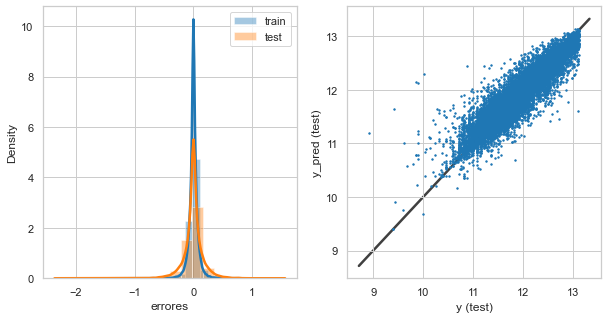

In [105]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

Es un modelo que da muy buenos resultados, un poco mejores que los modelos simples, aunque tiene un poco de sobreajuste.

### Random forest
Usamos el modelo de Random Forest Regressor por la gran performance vista en el modelo de Tree Regressor.

In [106]:
rf = RandomForestRegressor(random_state = 42)

In [107]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1200, num = 12)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
               'min_samples_split': [2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5,10],
               'bootstrap': [True, False]}


In [108]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, n_jobs = -1, cv = 3, verbose = 3, random_state = 42)

**ATENCIÓN: ESTE PROCESO DEMANDA MUCHOS RECURSOS Y PUEDE TARDAR EN COMPLETARSE**

In [109]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 18.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [200, 290, 381, 472,
                                                         563, 654, 745, 836,
                                                         927, 1018, 1109,
                                                         1200]},
                   random_state=42, verbose=3)

In [110]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25,
 'bootstrap': False}

In [111]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=25, max_features='sqrt',
                      n_estimators=1200, random_state=42)

In [112]:
rf_random.best_score_

0.873041259540868

In [113]:
RFR = RandomForestRegressor(n_estimators = 1200, min_samples_split = 2, min_samples_leaf = 1,
                            max_features = 'sqrt', max_depth = 25, bootstrap = False)
RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=25, max_features='sqrt',
                      n_estimators=1200)

In [114]:
y_train_pred = RFR.predict(X_train)
y_test_pred = RFR.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'MAE Train: {(mean_absolute_error(y_train, y_train_pred))}')
print(f'MAE Test: {(mean_absolute_error(y_test, y_test_pred))}')
print(f'MSE Train: {(mean_squared_error(y_train, y_train_pred))}')
print(f'MSE Test: {(mean_squared_error(y_test, y_test_pred))}')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print('\n')

MAE Train: 0.018020636464305472
MAE Test: 0.09223624479604872
MSE Train: 0.0019521653834553765
MSE Test: 0.027524193151106265
RMSE Train: 0.04418331566842145
RMSE Test: 0.16590416857664025




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'y_pred (test)')

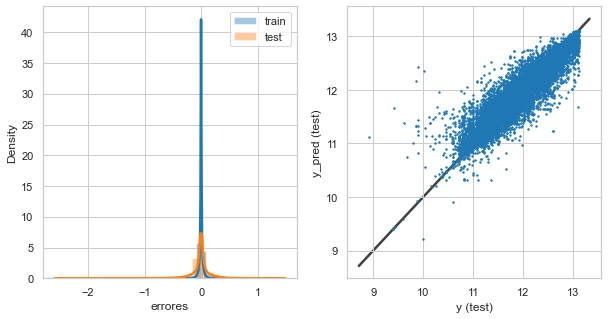

In [115]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


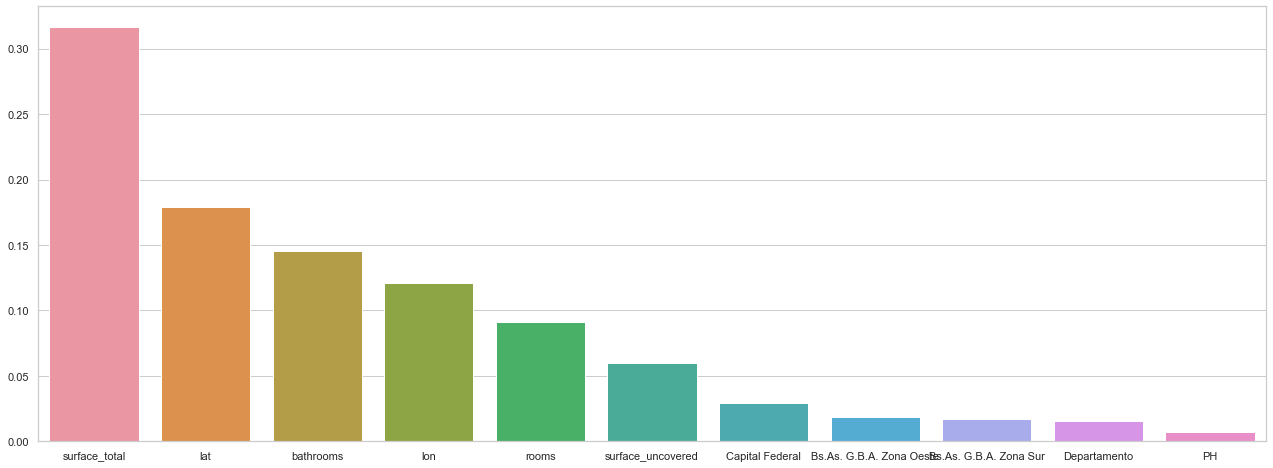

In [116]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = RFR.feature_importances_
# Tomamos la lista de palabras
columns = X_train.columns

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (22,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

Hasta ahora el que mejor performance tiene, sin embargo tiene un sobreajuste considerable. De nuevo la superficie total es la variable más importante, seguida por la latitud, la cantidad de baños y la longitud.

### **Regresión avanzada**
### Polynomial Features
Otro modelo que funcionó muy bien es el de regresión lineal, ahora intentaremos encontrar una mejor predicción con atributos polinómicos.

In [117]:
lreg_accuracy_train = []
lreg_accuracy_test = []
lreg_rmse_train = []
lreg_rmse_test = []


for i in range(2,6):
    poly = PolynomialFeatures(i, include_bias = False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    lreg = LinearRegression()
    lreg.fit(X_train_poly, y_train)
    
    y_train_pred = lreg.predict(X_train_poly)
    lreg_train_acc = mean_squared_error(y_train, y_train_pred)
    lreg_accuracy_train.append(lreg_train_acc)
    
    y_test_pred = lreg.predict(X_test_poly)
    lreg_test_acc = mean_squared_error(y_test, y_test_pred)
    lreg_accuracy_test.append(lreg_test_acc)
    
    lreg_rmse_train.append(np.sqrt(lreg_train_acc))
    lreg_rmse_test.append(np.sqrt(lreg_test_acc))
    

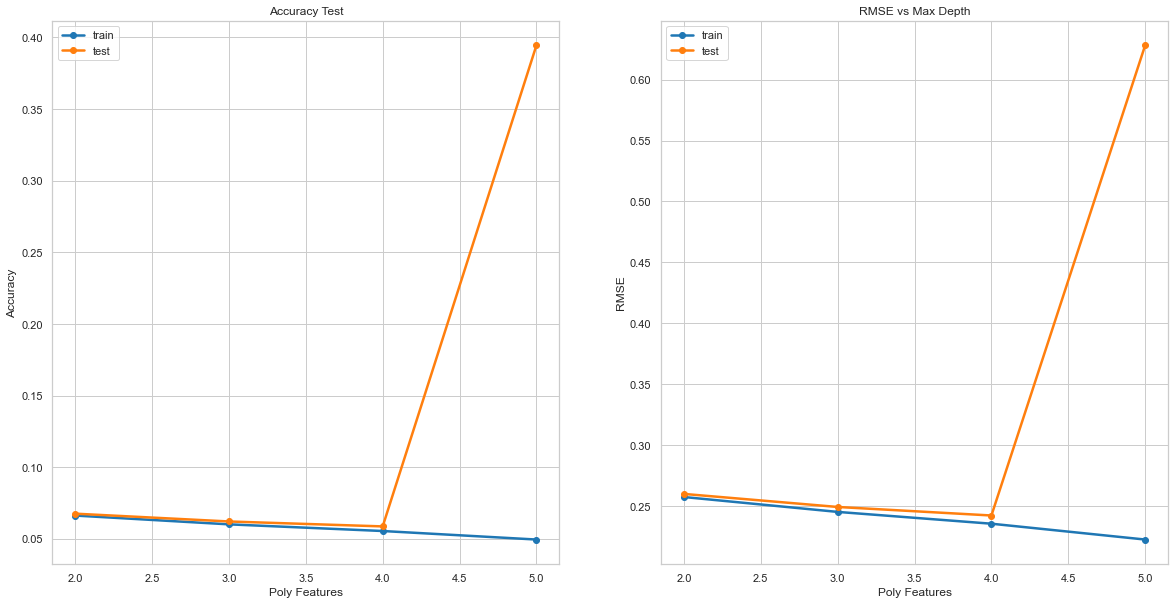

In [118]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(range(2,6), lreg_accuracy_train,marker = 'o', label = 'train')
plt.plot(range(2,6), lreg_accuracy_test,marker = 'o', label = 'test')

plt.title('Accuracy Test')
plt.xlabel('Poly Features')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(2,6), lreg_rmse_train,marker = 'o', label = 'train')
plt.plot(range(2,6), lreg_rmse_test,marker = 'o', label = 'test')

plt.title('RMSE vs Max Depth')
plt.xlabel('Poly Features')
plt.ylabel('RMSE')
plt.legend()

Vemos que a partir de los 4 atributos polinómicos baja considerablemente la métrica, por lo que nos detendremos ahí.

In [119]:
poly = PolynomialFeatures(4, include_bias=False)
X_new = poly.fit_transform(X)
print(X_new.shape)

X_poly = pd.DataFrame(X_new)

(96249, 1364)


Nos quedaron 1364 componentes principales, pero ahora con PCA los vamos a reducir a los necesarios para el modelo

### PCA

In [120]:
from sklearn.decomposition import PCA
covar_matrix = PCA(n_components = len(X_poly.columns))
covar_matrix.fit(X_poly)

PCA(n_components=1364)

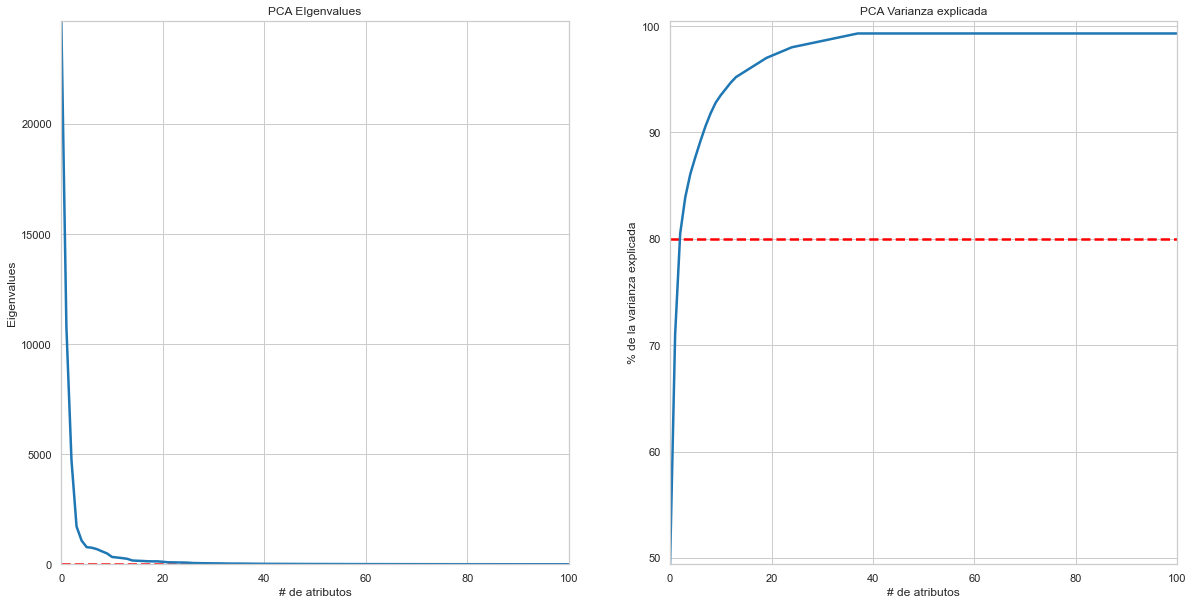

In [121]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.ylabel('Eigenvalues')
plt.xlabel('# de atributos')
plt.title('PCA EIgenvalues')
plt.xlim(0,100)
plt.ylim(0,max(covar_matrix.explained_variance_))
plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.plot(covar_matrix.explained_variance_)

variance = covar_matrix.explained_variance_ratio_
var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals = 3)*100)

plt.subplot(1,2,2)
plt.ylabel('% de la varianza explicada')
plt.xlabel('# de atributos')
plt.title('PCA Varianza explicada')
plt.xlim(0,100)
plt.ylim(min(var), 100.5)
plt.axhline(y = 80, color = 'r', linestyle = '--')
plt.plot(var)

Notamos que gran parte de la varianza se explica con los primeros 3 componentes principales, como veíamos anteriormente. Sin embargo, buscamos ahora dar con un modelo que supere el baseline y al no ser tantas variables, no tenemos problema aún con el tiempo de procesamiento. Como el porcentaje de varianza predicha se detiene cerca de los 40 atributos, vamos a utilizar esa cantidad para el modelo.

In [122]:
poly_pca = PCA(n_components = 40)
X_poly_pca = poly_pca.fit_transform(X_poly) 

In [123]:
X_poly_pca_df = pd.DataFrame(X_poly_pca)
X_poly_pca_df

0           1           2           3           4          5   \
0      -22.958302  -17.728070    5.321969    5.774617    0.315820  -0.108814   
1      -22.647350  -17.819665    5.233572    5.446477    0.408787   0.442393   
2      -20.816885  -18.009449    5.180735    7.278149    0.432102  -0.792269   
3       22.819458  655.345403 -191.923339   29.798562  -82.190182 -23.884467   
4      -22.794196  -17.805897    5.302096    5.786774    0.429191   0.272900   
...           ...         ...         ...         ...         ...        ...   
96244  -16.738334   82.903405  -30.848109   11.311044  -27.600072   7.160285   
96245  179.559084  139.761434 -295.991651 -121.757735  117.440138 -39.472532   
96246   -3.578940  243.388145  -56.759316    2.696576   73.146063 -60.222419   
96247    0.591762  248.862949  -27.615132   -2.874751   83.551679 -71.073452   
96248   -3.364657  240.760336  -60.008963   10.048134   30.591086 -70.144462   

               6           7           8           9   ...         30  \
0        1.199269    0.642392   -2.366438    3.486252  ...  -0.979740   
1        0.881807    0.612391   -3.220456    4.739712  ...  -0.541392   
2        1.503367    0.355843   -4.058356    3.639737  ...   0.063973   
3      -75.194035   16.789791   -6.590995   -0.193629  ...  -7.877974   
4        0.994860    0.562506   -3.233911    4.745344  ...  -0.511916   
...           ...         ...         ...         ...  ...        ...   
96244    8.387307   38.880356  -13.198598    2.093263  ...  -3.839995   
96245 -378.970788   72.783772  110.658469  100.993219  ... -43.053784   
96246 -139.763798 -282.152797   77.420888   35.952580  ...  -8.800067   
96247 -144.483341 -266.685418   66.455028   31.008301  ...  -2.197219   
96248 -187.041460 -209.492942   62.973286   38.162383  ...  -5.663409   

              31         32         33        34        35         36  \
0      -0.182413   0.868585  -0.402175  0.334591 -0.114597   0.231362   
1      -0.063393  -0.782216  -0.005688 -0.443297  0.879877   0.413171   
2      -0.296545  -0.432665  -0.730559 -0.491553  0.790692  -0.288062   
3       3.734332   1.023039   1.282652 -2.313983 -3.674110   5.808644   
4      -0.125820  -0.575143   0.019548 -0.309686  0.777399   0.318958   
...          ...        ...        ...       ...       ...        ...   
96244   5.664775  -6.561365  -8.042104 -1.755507  2.552908  -1.760385   
96245 -32.633450  -8.351534 -10.513718 -5.850478 -7.530839  45.764251   
96246  40.885611 -31.182180  -8.845364 -2.558365  3.407168   1.565546   
96247  18.486532 -30.265418 -15.040599  7.953342 -9.900658 -11.326175   
96248  -3.273919   2.993772  -9.566916  4.845737 -7.124483 -26.940305   

              37         38         39  
0      -0.380478  -0.370601  -0.678243  
1      -0.366484  -0.070021   0.499202  
2      -0.956432  -0.293890  -1.340235  
3     -12.319311   3.732852 -15.067033  
4      -0.419646  -0.206006   0.163552  
...          ...        ...        ...  
96244  11.718695   0.549213  -4.987350  
96245 -15.515955  23.130604 -16.273050  
96246  21.490872  32.140002 -23.786880  
96247  12.788477  -1.302419   1.371475  
96248 -20.674664 -25.101324  16.117305  

[96249 rows x 40 columns]

In [124]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_poly_pca_df, y, test_size=0.30, random_state=42)

In [125]:
reg_2 = LinearRegression()
reg_2.fit(X_train_new, y_train_new)
print(reg_2.coef_, reg_2.intercept_)
y_train_pred_2 = reg_2.predict(X_train_new)
y_test_pred_2 = reg_2.predict(X_test_new)

rmse_train = np.sqrt(mean_squared_error(y_train_new, y_train_pred_2))
rmse_test = np.sqrt(mean_squared_error(y_test_new, y_test_pred_2))
print(f'MAE Train: {(mean_absolute_error(y_train_new, y_train_pred_2))}')
print(f'MAE Test: {(mean_absolute_error(y_test_new, y_test_pred_2))}')
print(f'MSE Train: {(mean_squared_error(y_train_new, y_train_pred_2))}')
print(f'MSE Test: {(mean_squared_error(y_test_new, y_test_pred_2))}')
print(f'RMSE Train: {rmse_train}')
print(f'RMSE Test: {rmse_test}')
print('\n')

[-4.07289437e-05 -7.53172738e-04  2.02731566e-04 -2.23374305e-03
 -3.75595196e-04 -1.66646272e-03  1.45067834e-03  6.58918225e-04
  2.46754391e-03 -5.68937828e-03  4.55608837e-04 -1.84378954e-04
  5.60789823e-04 -2.52248284e-04 -2.75183514e-03  1.87351596e-03
 -2.16998025e-03 -3.84121782e-03  4.81679049e-04 -1.61692163e-03
  3.74455226e-05  5.87615179e-03 -2.50182041e-03  2.44895145e-03
 -1.16108060e-03  1.72932197e-03 -6.55768701e-03 -1.36090039e-03
 -7.21533430e-03 -3.67062644e-04 -3.24706523e-03 -5.07932565e-03
  1.35832351e-02  1.26510364e-02  1.42670277e-02 -8.32712392e-03
 -1.07276941e-02 -2.73294706e-03 -3.24246613e-03 -1.78242132e-02] 11.939018494432975
MAE Train: 0.31822782206588063
MAE Test: 0.31814621093037154
MSE Train: 0.16572619786166312
MSE Test: 0.1690801561894117
RMSE Train: 0.4070948266210996
RMSE Test: 0.4111935750828455




In [126]:
print(reg_2.coef_, reg_2.intercept_)

[-4.07289437e-05 -7.53172738e-04  2.02731566e-04 -2.23374305e-03
 -3.75595196e-04 -1.66646272e-03  1.45067834e-03  6.58918225e-04
  2.46754391e-03 -5.68937828e-03  4.55608837e-04 -1.84378954e-04
  5.60789823e-04 -2.52248284e-04 -2.75183514e-03  1.87351596e-03
 -2.16998025e-03 -3.84121782e-03  4.81679049e-04 -1.61692163e-03
  3.74455226e-05  5.87615179e-03 -2.50182041e-03  2.44895145e-03
 -1.16108060e-03  1.72932197e-03 -6.55768701e-03 -1.36090039e-03
 -7.21533430e-03 -3.67062644e-04 -3.24706523e-03 -5.07932565e-03
  1.35832351e-02  1.26510364e-02  1.42670277e-02 -8.32712392e-03
 -1.07276941e-02 -2.73294706e-03 -3.24246613e-03 -1.78242132e-02] 11.939018494432975


C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'y_pred (test)')

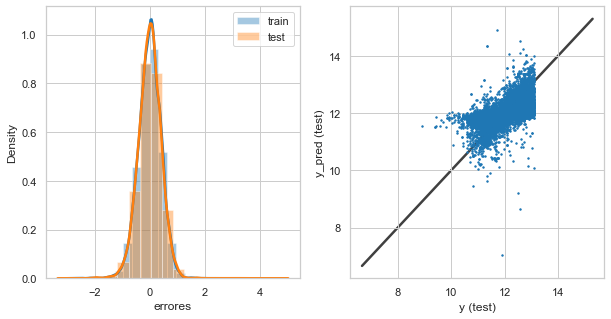

In [127]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.distplot(y_train_new - y_train_pred_2, bins = 20, label = 'train')
sns.distplot(y_test_new - y_test_pred_2, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test_new,y_test_pred_2, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

No ha sido un modelo superador con los atributos polinómicos, así que intentaremos con otros modelos de regresión. Vamos a utilizar los datos anteriores a los atributos polinómicos debido a que fueron los que mejores resultados nos dieron y también para mantener la interpretabilidad de los modelos.

### Ridge
Ridge regression adds penalty equivalent to the square of the magnitude of the coefficients. This penalty is added to the least square loss function above and looks like this...

In [128]:
alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    ridge = Ridge(alpha = i, normalize = True)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [129]:
temp_mse

{-3: 23.515546902862912,
 -2: 5.199814498236561,
 -1: 0.3945934889429594,
 1e-15: 0.08983945168899952,
 1e-10: 0.08983945168932649,
 1e-08: 0.08983945172169738,
 1e-05: 0.08983948460761648,
 0.0001: 0.08983980072105367,
 0.001: 0.08984488768620776,
 0.01: 0.09005479499723536,
 0.5: 0.1124991664331999,
 1: 0.12632772613872065,
 1.5: 0.13799139278418424,
 2: 0.14797108986500215,
 3: 0.16387418966757533,
 4: 0.17579663830948056,
 5: 0.18498837377726243,
 10: 0.21056045546153537,
 20: 0.2288819909071203,
 30: 0.23618980742350626,
 40: 0.2401165086506183}

In [130]:
temp_rss

{-3: 679011.4168201667,
 -2: 150144.64363658117,
 -1: 11393.886993227914,
 1e-15: 2594.114167519854,
 1e-10: 2594.1141675292947,
 1e-08: 2594.114168463973,
 1e-05: 2594.1151180449397,
 0.0001: 2594.1242458204315,
 0.001: 2594.2711319392447,
 0.01: 2600.3322055451986,
 0.5: 3248.4134307586833,
 1: 3647.7130922555334,
 1.5: 3984.5014666433062,
 2: 4272.665219851933,
 3: 4731.867226651199,
 4: 5076.127931186263,
 5: 5341.539292818424,
 10: 6079.933151451851,
 20: 6608.967487443089,
 30: 6819.980689353772,
 40: 6933.364187286595}

### Lasso
Lasso adds penalty equivalent to the absolute value of the sum of coefficients. This penalty is added to the least square loss function and replaces the squared sum of coefficients from Ridge. 


In [131]:
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    lasso_reg = Lasso(alpha = i, normalize = True) 
    lasso_reg.fit(X_train, y_train)
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred - y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [132]:
temp_mse

{-3: 58556140.896986015,
 -2: 26024953.34610022,
 -1: 6506239.743717995,
 1e-15: 0.08983945168901199,
 1e-10: 0.08983945293724835,
 1e-08: 0.08983957682858483,
 1e-05: 0.0901562078430887,
 0.0001: 0.10261650204684727,
 0.001: 0.24151127439782683,
 0.01: 0.25315273230714175,
 0.5: 0.25315273230714175,
 1: 0.25315273230714175,
 1.5: 0.25315273230714175,
 2: 0.25315273230714175,
 3: 0.25315273230714175,
 4: 0.25315273230714175,
 5: 0.25315273230714175,
 10: 0.25315273230714175,
 20: 0.25315273230714175,
 30: 0.25315273230714175,
 40: 0.25315273230714175}

In [133]:
temp_rss

{-3: 1690808568400.4739,
 -2: 751470527868.6469,
 -1: 187867672599.85498,
 1e-15: 2594.1141675202302,
 1e-10: 2594.1142035630496,
 1e-08: 2594.1177809253913,
 1e-05: 2603.260501469207,
 0.0001: 2963.051496602721,
 0.001: 6973.638048237273,
 0.01: 7309.785145368872,
 0.5: 7309.785145368872,
 1: 7309.785145368872,
 1.5: 7309.785145368872,
 2: 7309.785145368872,
 3: 7309.785145368872,
 4: 7309.785145368872,
 5: 7309.785145368872,
 10: 7309.785145368872,
 20: 7309.785145368872,
 30: 7309.785145368872,
 40: 7309.785145368872}

### Elastic Net
Elastic Net is the combination of both Ridge and Lasso. It adds both the sum of squared coefficients and the absolute sum of the coefficients with the ordinary least square function. Let's look at the function. 

In [134]:
temp_rss = {}
temp_mse = {}
for i in alpha_ridge:
    elastic_reg = ElasticNet(alpha = i, normalize=True)
    elastic_reg.fit(X_train, y_train)
    y_pred = elastic_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred - y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [135]:
temp_mse

{-3: 0.26448344521639655,
 -2: 0.2644864611237756,
 -1: 0.2644955094134067,
 1e-15: 0.08983945168911588,
 1e-10: 0.08983946335402924,
 1e-08: 0.08984086040116548,
 1e-05: 0.10759081261856977,
 0.0001: 0.1733951413216607,
 0.001: 0.24697541248936997,
 0.01: 0.25315273230714175,
 0.5: 0.25315273230714175,
 1: 0.25315273230714175,
 1.5: 0.25315273230714175,
 2: 0.25315273230714175,
 3: 0.25315273230714175,
 4: 0.25315273230714175,
 5: 0.25315273230714175,
 10: 0.25315273230714175,
 20: 0.25315273230714175,
 30: 0.25315273230714175,
 40: 0.25315273230714175}

In [136]:
temp_rss

{-3: 7636.959480623474,
 -2: 7637.046564949071,
 -1: 7637.307834312136,
 1e-15: 2594.114167523234,
 1e-10: 2594.1145043475863,
 1e-08: 2594.154844083649,
 1e-05: 3106.684714361203,
 0.0001: 5006.784705662897,
 0.001: 7131.415035630512,
 0.01: 7309.785145368872,
 0.5: 7309.785145368872,
 1: 7309.785145368872,
 1.5: 7309.785145368872,
 2: 7309.785145368872,
 3: 7309.785145368872,
 4: 7309.785145368872,
 5: 7309.785145368872,
 10: 7309.785145368872,
 20: 7309.785145368872,
 30: 7309.785145368872,
 40: 7309.785145368872}

### Instanciamos y entrenamos todos los modelos

In [137]:
ridge = Ridge(alpha= 0.01, normalize=True)
ridge.fit(X_train, y_train)
lasso_reg = Lasso(alpha= 1e-8, normalize=True)
lasso_reg.fit(X_train, y_train)
elastic_reg = ElasticNet(alpha= 1e-8, normalize=True)
elastic_reg.fit(X_train, y_train)

ElasticNet(alpha=1e-08, normalize=True)

In [138]:
ridgecoef = pd.DataFrame(ridge.coef_, X_train.columns, columns = ['Coef_ridge'])
lassocoef = pd.DataFrame(lasso_reg.coef_, X_train.columns, columns = ['Coef_lasso'])
elnetcoef = pd.DataFrame(elastic_reg.coef_, X_train.columns, columns = ['Coef_elnet'])
print(ridge.intercept_)
print(lasso_reg.intercept_)
print(elastic_reg.intercept_)
pd.concat([ridgecoef, lassocoef, elnetcoef], axis=1)

11.525882261985751
11.49054292227655
11.491835394844898


Coef_ridge  Coef_lasso  Coef_elnet
lat                         0.196409    0.208050    0.207630
lon                         0.145014    0.152732    0.152464
rooms                       0.012677   -0.000267    0.000200
bathrooms                   0.088583    0.083758    0.083938
surface_total               0.383498    0.413560    0.412469
surface_uncovered          -0.148199   -0.165319   -0.164697
Bs.As. G.B.A. Zona Oeste   -0.028575   -0.000584   -0.001613
Bs.As. G.B.A. Zona Sur     -0.099919   -0.075955   -0.076868
Capital Federal             0.185093    0.196289    0.195869
Departamento                0.324402    0.349555    0.348645
PH                          0.128121    0.152046    0.151183

No notamos grandes diferencias entre los modelos, podemos ver que la superficie total, departamento, latitud, Capital Federal, longitud son los coeficientes más importantes.

Loop 1: 0it [00:00, ?it/s]

Modelo: Ridge


MAE Train: 0.2306283574305685
MAE Test: 0.2306649762612727
MSE Train: 0.08938909720308422
MSE Test: 0.09005479499723536
RMSE Train: 0.29898009499477424
RMSE Test: 0.3000913110991975




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Loop 1: 1it [00:01,  1.35s/it]

Modelo: Lasso


MAE Train: 0.23009028537274637
MAE Test: 0.23020635650848312
MSE Train: 0.0892046443709888
MSE Test: 0.08983957682858483
RMSE Train: 0.2986714656122824
RMSE Test: 0.29973250879506685




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Loop 1: 2it [00:02,  1.37s/it]

Modelo: Elastic Net


MAE Train: 0.2301009246014344
MAE Test: 0.2302141506515573
MSE Train: 0.0892049009104919
MSE Test: 0.08984086040116548
RMSE Train: 0.29867189507968755
RMSE Test: 0.29973464998422433




C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Loop 1: 3it [00:04,  1.48s/it]


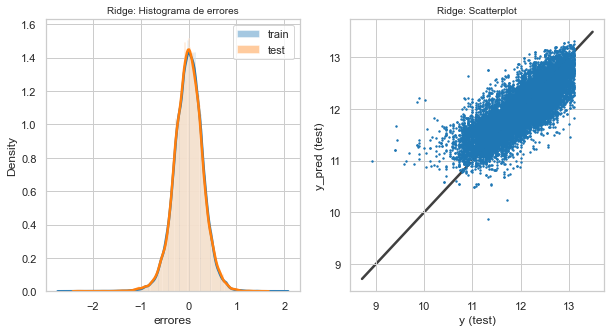

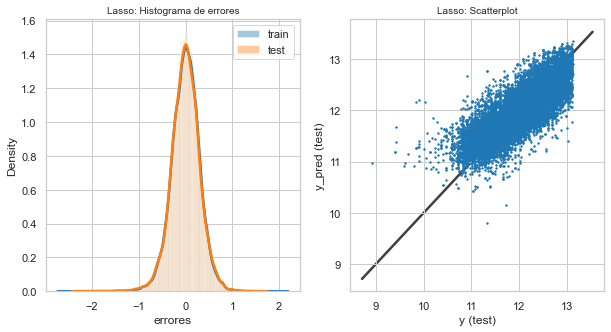

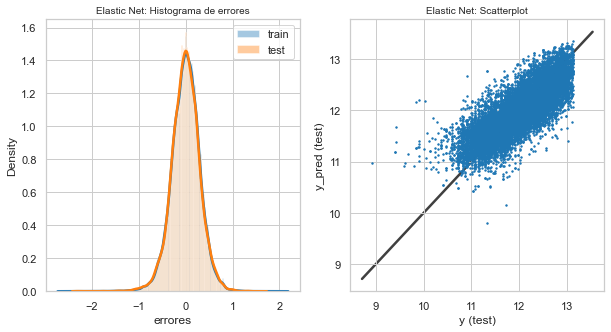

In [139]:
modelos = ['Ridge', 'Lasso', 'Elastic Net']

for i, model in tqdm(enumerate([ridge, lasso_reg, elastic_reg]), desc = 'Loop 1', leave = True):
    time.sleep(0.5)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')
    print('\n')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'MAE Train: {(mean_absolute_error(y_train, y_train_pred))}')
    print(f'MAE Test: {(mean_absolute_error(y_test, y_test_pred))}')
    print(f'MSE Train: {(mean_squared_error(y_train, y_train_pred))}')
    print(f'MSE Test: {(mean_squared_error(y_test, y_test_pred))}')
    print(f'RMSE Train: {rmse_train}')
    print(f'RMSE Test: {rmse_test}')
    print('\n')
    
    plt.figure(figsize = (10,5))

    plt.subplot(1,2,1)
    plt.title(f'{modelos[i]}: Histograma de errores', fontsize= 10)
    sns.distplot(y_train - y_train_pred, label = 'train', bins= 200)
    sns.distplot(y_test - y_test_pred, label = 'test', bins= 200)
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    plt.title(f'{modelos[i]}: Scatterplot', fontsize= 10)
    ax.scatter(y_test,y_test_pred, s = 2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, 'k-', alpha = 0.75, zorder = 0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    

### **Comparativa de modelos**
Vamos a elaborar una tabla con los resultados de accuracy con Cross Validation para cada modelo, y los contrastamos con los resultados del anterior tp. Para esta comparativa vamos a usar los datos del principio de esta sección, es decir, sin pasar por Polynomial Features, porque para los modelos de regresión avanzada nos han dado mejores resultados.

Para las metricas vamos a utilizar las ya empleadas MAE, MSE, RMSE y R2 para realizar un benchmark entre modelos de regresión.


* MSE(Mean Squared Error)
> MSE o Error al cuadrado medio es una de las métricas más preferidas para las tareas de regresión. Es simplemente el promedio de la diferencia al cuadrado entre el valor objetivo y el valor predicho por el modelo de regresión. A medida que cuadra las diferencias, penaliza incluso un pequeño error que conduce a una sobreestimación de cuán malo es el modelo. Se prefiere más que otras métricas porque es diferenciable y, por lo tanto, se puede optimizar mejor.

### $$\operatorname{MSE}= \frac{1}{n}\sum_{i=1}^n(\hat{y_i} - y_i)^2$$

* MAE (Mean Absolute Error)
> MAE es la diferencia absoluta entre el valor objetivo y el valor predicho por el modelo. El MAE es más robusto para los valores atípicos y no penaliza los errores tan extremadamente como el mse. MAE es una puntuación lineal que significa que todas las diferencias individuales se ponderan por igual. No es adecuado para aplicaciones en las que desea prestar más atención a los valores atípicos.
### $$\operatorname{MAE} = \frac{\sum_{i=1}^n|{\bar{y} - y_i}|}{n}$$

* RMSE (Root Mean Squared Error)
> RMSE es la métrica más utilizada para tareas de regresión y es la raíz cuadrada de la diferencia cuadrática promedio entre el valor objetivo y el valor predicho por el modelo. Se prefiere más en algunos casos porque los errores se cuadran primero antes del promedio, lo que representa una penalización alta en errores grandes. Esto implica que RMSE es útil cuando no se desean errores grandes.
### $$ \operatorname{RMSE}= \sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{y_i} - y_i)^2} $$

* $y_i$ = Cada dato observado  
* $\bar{y}$ = La media de los valores
* $\hat{y_i}$ = Cada predicción de $x_i$ dependiente de i


**Comparación RMSE vs MAE**

Similitudes :

   > Expresar el error promedio de predicción del modelo en las mismas unidades de la variable de interés.
    Puede variar de 0 a ∞ y son indiferentes a la dirección de los errores.
    Los valores más bajos son mejores.
    MAE y RMSE tienen las mismas unidades que los valores objetivo
    Son indiferentes a la dirección de los errores (tomamos un valor absoluto o cuadramos cada residual)
    Cuanto menor sea el valor métrico, mejor

Diferencia :

   > Tomando la raíz cuadrada antes de promediar, RMSE otorga un peso relativamente alto a los errores grandes, por lo que RMSE debería ser útil cuando los errores grandes no son deseables
    RMSE otorga un peso relativamente alto a los errores grandes debido al hecho de que el residuo se eleva al cuadrado antes del promedio
    Por otro lado, promediar valores absolutos hace que MAE sea más robusto para los valores atípicos
    RMSE es diferenciable (que es correcto, pero no realmente importante para una métrica de evaluación)

* $R^2$("Coeficiente de determinación"): 
> $R^2$ y $R^2$ ajustado se utilizan a menudo con fines explicativos y explica qué tan bien las variables independientes seleccionadas explican la variabilidad en sus variables dependientes. Determina la capacidad de un modelo para predecir futuros resultados. El mejor resultado posible es 1.0, y ocurre cuando la predicción coincide con los valores de la variable objetivo. R2 puede tomar valores negativos pues la predicción puede ser arbitrariamente mala. Cuando la predicción coincide con la esperanza de los valores de la variable objetivo, el resultado de R2 es 0. Se define como 1 menos la suma de cuadrados totales dividido por la suma de cuadrados de los residuos: 

# $$ \operatorname{R^2} = 1 - \frac{\sum_{i=1}^n \left({y_i} - {p_i}\right)^2}{\sum_{i=1}^n \left(y_i - \bar{y}\right)^2} $$

* yi son los valores que toma la variable objetivo
* pi son los valores de la predicción
* ȳ es el valor medio de los valores que toma la variable objetivo



In [141]:
from sklearn.metrics import make_scorer
scoring = {'MAE': 'neg_mean_absolute_error',
           'MSE': 'neg_mean_squared_error',
           'RMSE': 'neg_root_mean_squared_error',
          'R2': 'r2'}

In [142]:
scores = cross_validate(ridge, X, y, scoring = scoring,
                        cv = 5, return_train_score = True)
for key in scores.keys():
    print(f'{key}: {(scores[key].mean())}')
scores.keys()

fit_time: 0.01754899024963379
score_time: 0.004784631729125977
test_MAE: -0.23092624933124556
train_MAE: -0.2306465564909383
test_MSE: -0.08976956972807434
train_MSE: -0.08954895172981993
test_RMSE: -0.2996009130800183
train_RMSE: -0.2992462942337973
test_R2: 0.6449028070132421
train_R2: 0.6464449410337721


dict_keys(['fit_time', 'score_time', 'test_MAE', 'train_MAE', 'test_MSE', 'train_MSE', 'test_RMSE', 'train_RMSE', 'test_R2', 'train_R2'])

In [143]:
model_comparison = pd.DataFrame(data = None, columns = ['Model','Fit time','Score time','Test MAE','Train MAE','Test MSE','Train MSE','Test RMSE','Train RMSE', 'Test R2', 'Train R2'])
model_comparison

Empty DataFrame
Columns: [Model, Fit time, Score time, Test MAE, Train MAE, Test MSE, Train MSE, Test RMSE, Train RMSE, Test R2, Train R2]
Index: []

Puede que tarde un poco en correr el codigo porque XGBoost y Random Forest consumen muchos recursos.

In [144]:
modelos = ['Tree', 'KNN', 'LReg','XGB', 'RF', 'Ridge', 'Lasso', 'Elastic Net']

for i, model in tqdm(enumerate([tree, knn, reg1, true_xg_reg, RFR, ridge, lasso_reg, elastic_reg]), desc = 'Loop 1', leave = True):
    
    model.fit(X_train,y_train)
    
    scores = cross_validate(model, X, y, scoring = scoring,
                        cv = 5, return_train_score = True)
    
    resultados = [f'{modelos[i]}']
    
    for key in scores.keys():
        resultados.append(scores[key].mean())
    model_comparison.loc[len(model_comparison)] = resultados
        
    print(f'Modelo {modelos[i]} procesado')

Loop 1: 1it [00:01,  1.99s/it]

Modelo Tree procesado


Loop 1: 2it [00:20,  7.09s/it]

Modelo KNN procesado


Loop 1: 3it [00:21,  5.03s/it]

Modelo LReg procesado


Loop 1: 4it [01:32, 24.83s/it]

Modelo XGB procesado


Loop 1: 5it [18:08, 316.22s/it]

Modelo RF procesado


Loop 1: 6it [18:08, 221.43s/it]

Modelo Ridge procesado


Loop 1: 7it [18:09, 155.14s/it]

Modelo Lasso procesado


Loop 1: 8it [18:09, 136.20s/it]

Modelo Elastic Net procesado


In [145]:
model_comparison.iloc[:,1:9] = model_comparison.iloc[:,1:9].abs()

In [146]:
model_comparison

Model    Fit time  Score time  Test MAE  Train MAE  Test MSE  \
0         Tree    0.305782    0.008174  0.116078   0.013652  0.047494   
1          KNN    0.351058    0.730843  0.138455   0.105354  0.044764   
2         LReg    0.027725    0.003990  0.230424   0.230139  0.089593   
3          XGB   11.721663    0.085160  0.104223   0.050320  0.027918   
4           RF  144.622156    5.939521  0.092667   0.019014  0.027450   
5        Ridge    0.026528    0.004786  0.230926   0.230647  0.089770   
6        Lasso    0.067026    0.004982  0.230424   0.230140  0.089593   
7  Elastic Net    0.058843    0.005186  0.230435   0.230151  0.089593   

   Train MSE  Test RMSE  Train RMSE   Test R2  Train R2  
0   0.001895   0.217524    0.043526  0.812159  0.992519  
1   0.027104   0.211507    0.164627  0.822941  0.892989  
2   0.089363   0.299305    0.298935  0.645601  0.647179  
3   0.006626   0.166936    0.081395  0.889568  0.973840  
4   0.002089   0.165376    0.045708  0.891421  0.991750  
5   0.089549   0.299601    0.299246  0.644903  0.646445  
6   0.089363   0.299305    0.298935  0.645601  0.647179  
7   0.089363   0.299305    0.298936  0.645602  0.647178

### Comparativa de tiempo de entrenamiento y evaluación

<AxesSubplot:xlabel='Model', ylabel='Fit time'>

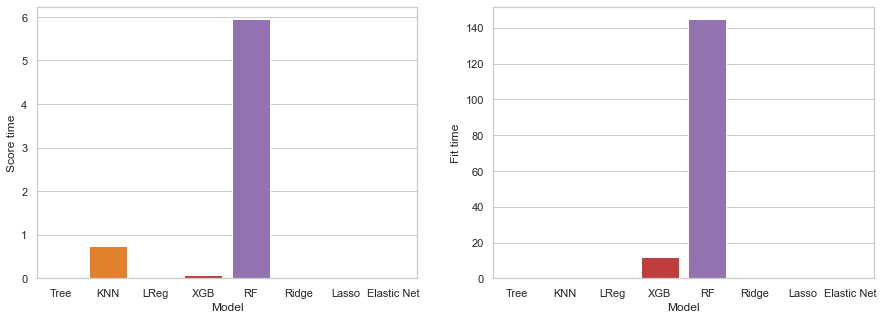

In [147]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
sns.barplot(data = model_comparison, x = 'Model', y = 'Score time', ax = ax)

ax2 = f.add_subplot(122)
sns.barplot(data = model_comparison, x = 'Model', y = 'Fit time', ax = ax2)

Vemos que el modelo de Random Forest consume mucho tiempo y recursos para realizar sus predicciones. Le sigue el de KNN pero muy por detrás, mientras que el resto de los modelos se ubican dentro de los milisegundos.

### Comparativa de métricas RMSE y R2

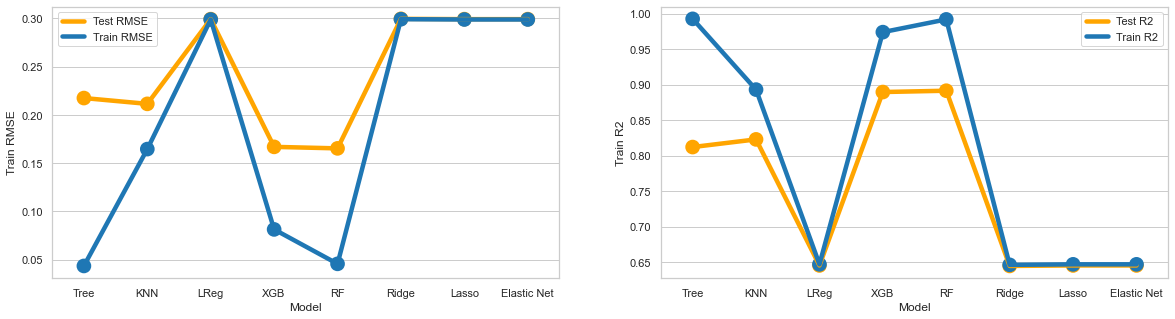

In [148]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
sns.pointplot(data = model_comparison, x = 'Model', y = 'Test RMSE', label = 'Test RMSE', ax = ax, color = 'Orange')
sns.pointplot(data = model_comparison, x = 'Model', y = 'Train RMSE', label = 'Train RMSE', ax = ax)


ax.legend(handles = ax.lines[::len(model_comparison)+1], labels = ['Test RMSE','Train RMSE'])

ax = f.add_subplot(122)
sns.pointplot(data = model_comparison, x = 'Model', y = 'Test R2', ax = ax, color = 'Orange')
sns.pointplot(data = model_comparison, x = 'Model', y = 'Train R2', ax = ax)

ax.legend(handles = ax.lines[::len(model_comparison)+1], labels = ['Test R2','Train R2'])

### **Justificacion de modelo elegido y comparacion con tp1**

No parece haber un claro ganador. Si incluimos la variable tiempo, a pesar de dar los mejores resultados, el modelo de Random Forest consume mucho tiempo. RF y el modelo de árboles de decisión muestran un claro sobreajuste, que en el caso del árbol podría mejorarse realizando un ajuste de hiperparámetros, como se hizo con el RF. El modelo de XGBoost, al igual que RF presenta un sobreajuste marcado, prácticamente iguala a RF en performance y tarda menos tiempo en entrenar. Los modelos de regresión obtienen los mismos resultados tanto en los datos de testeo como los datos de entrenamiento, lo cual significa que han sido bien ajustados los hiperparámetros, pero no no son los que mejores resultados han dado. El modelo de KNN parece un intermedio razonable, no presenta un gran sobreajuste y el rendimiento está entre los mejores. Si consideramos que es posible ajustar sus hiperparámetros, conseguiríamos mejores resultados.

### Traemos el modelo elegido de Vecinos Cercanos del tp1 y lo evaluamos junto con los modelos probados
El modelo del TP1 fue probado en datos prácticamente sin preprocesamiento ni escalado.

In [149]:
mlprop = pd.read_csv('DS_Proyecto_02_Datos_Properati.csv')

In [150]:
filter_list = ['Departamento', 'Casa', 'PH','Capital Federal']
filtered_mlprop = mlprop[(mlprop.property_type.isin(filter_list)) & (mlprop.l2.isin(filter_list))]
filtered_mlprop = filtered_mlprop[(filtered_mlprop.surface_total <= 1000) & (filtered_mlprop.surface_total >= 15)]
filtered_mlprop = filtered_mlprop[(filtered_mlprop.price <= 4000000)]
filtered_mlprop.drop(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3','currency', 'title', 'description', 'property_type','operation_type'], axis = 1,inplace = True)
filtered_mlprop = filtered_mlprop.dropna()
filtered_mlprop

rooms  bedrooms  bathrooms  surface_total  surface_covered      price
0         7.0       7.0        2.0          140.0            140.0   153000.0
1         2.0       1.0        2.0           70.0             58.0   159000.0
2         2.0       1.0        1.0           45.0             45.0   125000.0
3         2.0       1.0        1.0           85.0             50.0   295000.0
5         2.0       1.0        1.0           56.0             56.0   150000.0
...       ...       ...        ...            ...              ...        ...
146554    4.0       3.0        3.0          175.0            111.0   570000.0
146555    3.0       2.0        2.0          144.0            134.0   480000.0
146556    4.0       2.0        2.0          317.0            143.0   530000.0
146557    3.0       2.0        2.0          145.0            145.0   420000.0
146558    4.0       3.0        5.0          220.0            210.0  1470000.0

[81019 rows x 6 columns]

In [151]:
X = filtered_mlprop.drop('price', axis = 1)
y = filtered_mlprop['price']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [153]:
knn_regressor = KNeighborsRegressor(n_neighbors = 10)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [154]:
scores = cross_validate(knn_regressor, X, y, scoring = scoring,
                        cv = 5, return_train_score = True)

knn_1 = ['KNN TP1']
    
for key in scores.keys():
    knn_1.append(scores[key].mean())
model_comparison.loc[len(model_comparison)] = knn_1

In [155]:
model_comparison.iloc[:,1:9] = model_comparison.iloc[:,1:9].abs()
model_comparison

Model    Fit time  Score time      Test MAE     Train MAE  \
0         Tree    0.305782    0.008174      0.116078      0.013652   
1          KNN    0.351058    0.730843      0.138455      0.105354   
2         LReg    0.027725    0.003990      0.230424      0.230139   
3          XGB   11.721663    0.085160      0.104223      0.050320   
4           RF  144.622156    5.939521      0.092667      0.019014   
5        Ridge    0.026528    0.004786      0.230926      0.230647   
6        Lasso    0.067026    0.004982      0.230424      0.230140   
7  Elastic Net    0.058843    0.005186      0.230435      0.230151   
8      KNN TP1    0.128264    0.128451  66077.505400  58433.086066   

       Test MSE     Train MSE      Test RMSE     Train RMSE   Test R2  \
0  4.749375e-02  1.894857e-03       0.217524       0.043526  0.812159   
1  4.476436e-02  2.710374e-02       0.211507       0.164627  0.822941   
2  8.959314e-02  8.936294e-02       0.299305       0.298935  0.645601   
3  2.791845e-02  6.625935e-03       0.166936       0.081395  0.889568   
4  2.745041e-02  2.089476e-03       0.165376       0.045708  0.891421   
5  8.976957e-02  8.954895e-02       0.299601       0.299246  0.644903   
6  8.959303e-02  8.936294e-02       0.299305       0.298935  0.645601   
7  8.959298e-02  8.936328e-02       0.299305       0.298936  0.645602   
8  2.585495e+10  1.973375e+10  160452.621192  140467.408225  0.698464   

   Train R2  
0  0.992519  
1  0.892989  
2  0.647179  
3  0.973840  
4  0.991750  
5  0.646445  
6  0.647179  
7  0.647178  
8  0.778303

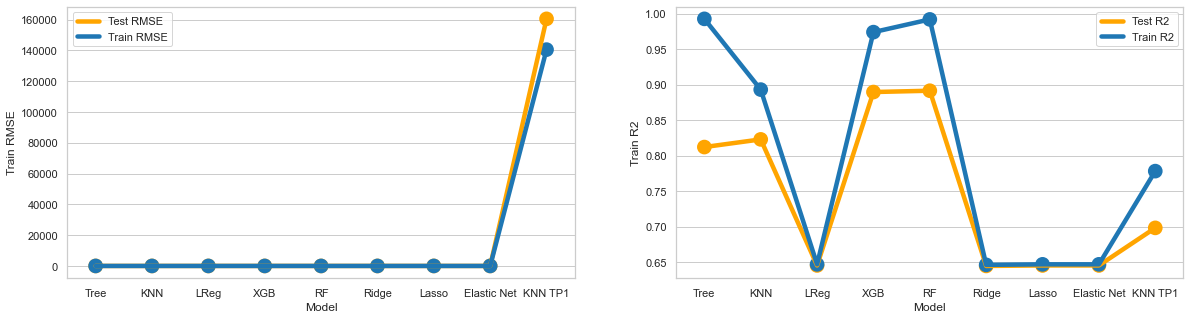

In [156]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(121)
sns.pointplot(data = model_comparison, x = 'Model', y = 'Test RMSE', label = 'Test RMSE', ax = ax, color = 'Orange')
sns.pointplot(data = model_comparison, x = 'Model', y = 'Train RMSE', label = 'Train RMSE', ax = ax)


ax.legend(handles = ax.lines[::len(model_comparison)+1], labels = ['Test RMSE','Train RMSE'])

ax = f.add_subplot(122)
sns.pointplot(data = model_comparison, x = 'Model', y = 'Test R2', ax = ax, color = 'Orange')
sns.pointplot(data = model_comparison, x = 'Model', y = 'Train R2', ax = ax)

ax.legend(handles = ax.lines[::len(model_comparison)+1], labels = ['Test R2','Train R2'])

### Conclusiones

Mejoramos mucho desde la última vez. La ingeniería de datos muestra que puede hacer la diferencia, aún más que el ajuste de hiperparámetros, y por ello es que quizás eligiendo un modelo simple obtengamos muy buenos resultados. Vimos que la ubicación, traducida en las variables de latitud y longitud, fueron un elemento clave para el modelo. La superficie y la cantidad de baños, como supusimos antes, también influyen mucho en el precio de la vivienda. No nos modificaron mucho los resultados las variables dummy (encoding de los distritos). Vemos que XGBoost y RandomForest consiguieron valores de R2 cerca de 1, lo cual es muy bueno. Si realizaramos un RandomizedSearchCV más profundo quizás estarían más cerca de solucionar el sobreajuste.

## ¡Muchas gracias por haber llegado hasta acá! ¡Espero que te haya servido!
Agradecimientos:
* Acámica, por el desafío
* Dominik Gawlik de Kaggle, por enseñarme a como automatizar gráficos
* Masum Rumi de Kaggle, por inspirarme con su trabajo de regresión avanzada
* Toda la comunidad de Data Science que nos aporta para nuestros trabajos

### *Francisco Garay Linares, DS-33 Acámica*


